In [1]:
%load_ext autoreload

SimRate
-------

SimRate simulates distributed workflows over a high latency network. 

It simuates:

    . a high-latency network.
    . network congestion
    . approximate TCP behavior, currently Reno/Cubic/HTCP(in progress)
    . distributed workflows. Currently only gridFTP is modeled.
  
The goal is to provide a fast simulator that allows to study how distributed workflow, large or small, long or short, compete over shared network resources. While SimRate needs to model a somewhat realistic TCP behavior, it is not intended to be used to study network protocols, allowing a faster simulation. Additionally, SimRate is not tested and may not support latencies less than 1 millisecond.
 
In order to be fast, SimRate does not model packets moving along a topology. Instead, SimRate models a data flow going through the network as its data rate. A flow data rate is not constant in times. It can change due to the following reasons:

    . congestion is detected on the path. The rate may decreases accordingly to the TCP model.
    . the path has been clean of any congestion, the rate may increase accordingly to the TCP model.
    . the workflow itself is dynamically paced at a given rate.
 
When the rate of a workflow changes, the event is progated through the network like a packet would, simulating routing and latencies. 

Another optimization is to detect congestion per flow as TCP would: it takes a round trip between the sender and the receiver to detected weither there has been packet losses or re-ordering. In other words, SimRate simulates the workflow behavior, based on their RTT, assuming that the data rate remains the same within a RTT period.

SimRate model makes the simulation very simple and fast. However, this comes at the cost of fairly inaccurate TCP behavior, especially in the contect of very short and very low latency flows.


SimRate is implemented in python, based on a discrete event simulation package SimPy. 

Try it out
----------
First, we need a network. The network is made of routers and links, forming its topology:

In [6]:
from simrate import Topology

topo = Topology("test topology", ticks_per_sec=1000)

The new topology object creates the SimRate environment and builds and empty graph. 

The option, ticks_per_sec, defines how much of real time is simulated per SimRate's clock tick. In this exemple, 100 ticks per second means that each simulator tick represents 1 ms of real time. Higher number means a better precision but may come at a high processing time. 

We can now start creating a simple topology of two routers, interconnected with a 100Gbps link and at a latency of 100ms. Note that the parameter is latency and not RTT.

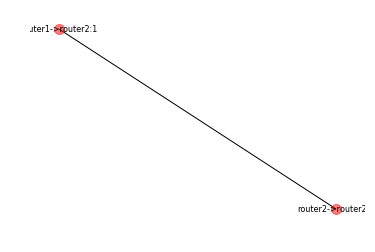

In [7]:
topo.add_link(router_a='router1',router_b='router2',capacity=10000,latency=100) 

topo.draw()

The next step is to create a source and destination of data through the topology. The following will create two servers, each connected to the opposite routers with a 10Gbs link. In this exemple, each of the servers will have a maximum data rate of 8Gbps. In SimRate, a server, or endpoint, is modeled as a router that terminates a path.

Note that the displayed topology represents ports connected by links. This means that routers will be displayed as a set of interconnected ports with links of zero latency. This would need improvement.

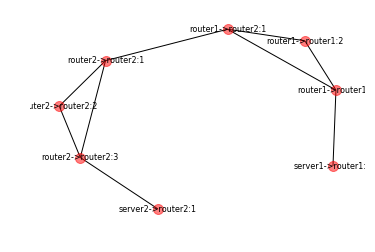

In [9]:
from simrate import Endpoint

server1 = Endpoint(name='server1',topology=topo,capacity=10000,rate=8000)
server1.connect('router1')
server2 = Endpoint(name='server2',topology=topo,capacity=10000,rate=8000)
server2.connect('router2')

topo.draw()

We can now create a workflow. Different kind of workflows may be implemented. Currently, the only workflow implementation models a gridFTP file transfer.

A default implementation is provided by sim.DataTransfer simulating a file transfer between two endpoints. It simulates the following features:
    - dynamic pacing,
    - path computation,
    - routing,
    - multi-stream.
    
The following creates a file transfer workflow. Source, destination, data size. The maximum flow rate is also provided. Other options include the number of parallel streams. Some of options are set directly onto the object. Note than the workflow object is created but not schedule yet. In other words, it is not yet active.

In [14]:
from simrate import DataTransfer

flow1 = DataTransfer(name="flow1",
                     src=server1,
                     dst=server2,
                     data_size=1000000,
                     max_rate=8000,
                     topology=topo)

flow1.info = True
flow1.debug = False
flow1.record_receive = True
                     

The  workflow is scheduled by calling the topology's SimRate environment. An optional starting time can be specified.

Obviously, the API should be simplified. 

In [15]:
topo.schedule_workflow(workflow=flow1)

Once all the workflows are created and scheduled, the simulation can start. It will automatically stop when all workflows have completed.

In [16]:
topo.start_simulation()

Simulation starts 135300.0
135300.0 start file transfer flow1
time: 135.2 secs flow1 rtt: 200 average 7396.44970414
Simulation stopped simulated elapse time: 135.3 real time: 0.0175700187683 real/simulate: 7700.61784134


The output means:
    . flow1 had an RTT of 200ms and went at an average if 7.3 Gbps for a duration of 135 seconds.
    . the overall simulation ran at a rate of 7700. This means that in one real time seconds, the simulated processed 7700 simulated seconds. This is really fast, but this was a single flow, without congestion.

The various outputs depends on the level of debug and traces. 


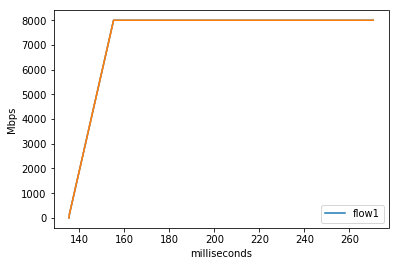

In [17]:
flow1.plot_receive()
topo.show_plots()

Congestion with large RTT
------------------------

In this exemple, we will add a third server, server3, connected to the same router than server2. Two flows will be created, from server1 to server2 and from server3 to server2, creating a congestion point on the router port connected to server2. The first flow, flow1, is going through a much longer path and therefore has a much higher RTT.

In [17]:
%aimport simrate
%autoreload 1
from simrate import Topology

import numpy as np

def init_congestion_model_reno(flow):
    flow.last_stable_rate = 0
    flow.stable_rates = []
    flow.increase_increment = 0

def increase(flow):
    now = flow.topology.now()
    if not flow.congested and flow.current_rate == flow.receive_rate:
        flow.last_stable_rate = flow.current_rate
        flow.stable_rates.append([float(now)/1000,flow.last_stable_rate])
    flow.increase_increment += 1
    flow.last_stable_rate = flow.current_rate
    rate = min (flow.current_rate + np.log(flow.increase_increment) * flow.increase_step, flow.max_rate)
    #rate = min (flow.current_rate + 
    if rate != flow.current_rate:
        flow.current_rate = rate
        return True
    return False

def decrease_reno(flow):
    flow.increase_increment = 0
    rate = max (int(flow.current_rate / 2), flow.increase_step)
    if rate != flow.current_rate:
        flow.current_rate = rate
        return True
    return False
    
def init_congestion_model_cubic(flow):
    flow.last_congestion = flow.topology.now()
    flow.rmax = 0
    flow.current_rate = flow.max_rate * 0.1
    flow.congestion_start = False
    
# rate_increase = (0.4* (time_since_last_congestion - (Rmax * RTT)**(1./3))**3 + Rmax * RTT) / RTT                
def increase_cubic(flow):
    flow.congestion_start = False
    now = float(flow.topology.now()) / 1000
    t = now - flow.last_congestion
    rate_increase = abs(0.4 * (t - (flow.rmax*flow.rtt)**(1./3))**3 + flow.rmax * flow.rtt)
    new_rate = min (flow.current_rate + rate_increase, flow.max_rate)
    if flow.current_rate != new_rate:
        flow.current_rate = new_rate
    flow.rmax = max(flow.rmax,flow.current_rate)

def decrease_cubic(flow):
    now = float(flow.topology.now()) / 1000
    #print flow.name,"decrease",flow.current_rate
    flow.last_congestion = now
    decrease_rate = 0.95
    if not flow.congestion_start:
        decrease_rate = 0.5
        flow.congestion_start = True
    flow.current_rate = max(flow.current_rate * decrease_rate, flow.max_rate * 0.05)
    
def init_congestion_model_htcp(flow):
    flow.last_congestion = flow.topology.now()
    flow.rmax = 15
    
def increase_htcp(flow):
    now = float(flow.topology.now()) / 1000
    new_rate = 0
    t = now - flow.last_congestion
    new_rate = min((t**3) * flow.current_rate / 100 , flow.max_rate) 
    if flow.current_rate != new_rate:
        flow.current_rate = new_rate
        return True
    return False

def decrease_htcp(flow):
    now = float(flow.topology.now()) / 1000
    flow.last_congestion = now
    flow.rmax = flow.current_rate
    flow.current_rate = flow.current_rate * 0.5
    return True
                
topo = Topology("test topology", ticks_per_sec=1000)

from simrate import Endpoint

topo.add_routers(['router1','router2'])
topo.add_link(router_a='router1',router_b='router2',capacity=10000,latency=44)

server1 = Endpoint(name='server1',topology=topo,capacity=10000,rate=10000)
server1.connect('router1', latency=1)
server2 = Endpoint(name='server2',topology=topo,capacity=10000,rate=10000)
server2.connect('router2', latency=1)
server3 = Endpoint(name='server3',topology=topo,capacity=10000,rate=10000)
server3.connect('router2', latency=1)

from simrate import DataTransfer

flow1 = DataTransfer(name="flow1",
                     src=server1,
                     dst=server2,
                     data_size=2000000,
                     max_rate=10000,
                     topology=topo,
                     increase=increase_cubic,
                     decrease=decrease_cubic)

flow1.info = True
flow1.debug = False
flow1.record_receive = True
flow1.record_drop = False
init_congestion_model_cubic(flow1)
flow1.congestion_loss = 1
flow1.record_congestion = True
flow1.congestion_rate_loss = 20

topo.schedule_workflow(workflow=flow1)

flow2 = DataTransfer(name="flow2",
                     src=server3,
                     dst=server2,
                     data_size=2000000,
                     max_rate=10000,
                     topology=topo,
                     increase=increase_cubic,
                     decrease=decrease_cubic)

flow2.info = True
flow2.debug = False
flow2.record_receive = True
flow2.record_drop = False
init_congestion_model_cubic(flow2)
flow2.record_congestion = True
flow2.congestion_rate_loss = 20

topo.schedule_workflow(workflow=flow2)
topo.start_simulation()


Simulation starts 0.0
0.0 start file transfer flow1
0.0 start file transfer flow2
time: 420.624 secs flow1 rtt: 92 average 4754.84042756
time: 502.148 secs flow2 rtt: 4 average 3982.88950668
Simulation stopped simulated elapse time: 502.15 real time: 7.97945904732 real/simulate: 62.9303311192


This times, the simlation takes more processing but it is still reasonable.

Every change of rate was recorded, in memory. The following shows how to visualize the flows.

Note that flow1 , high latency, is quite impacted by the lower latency flow. Of course, after the flow1 is done, flow2 can ramp up to its max rate.

flow1


<IPython.core.display.Javascript object>


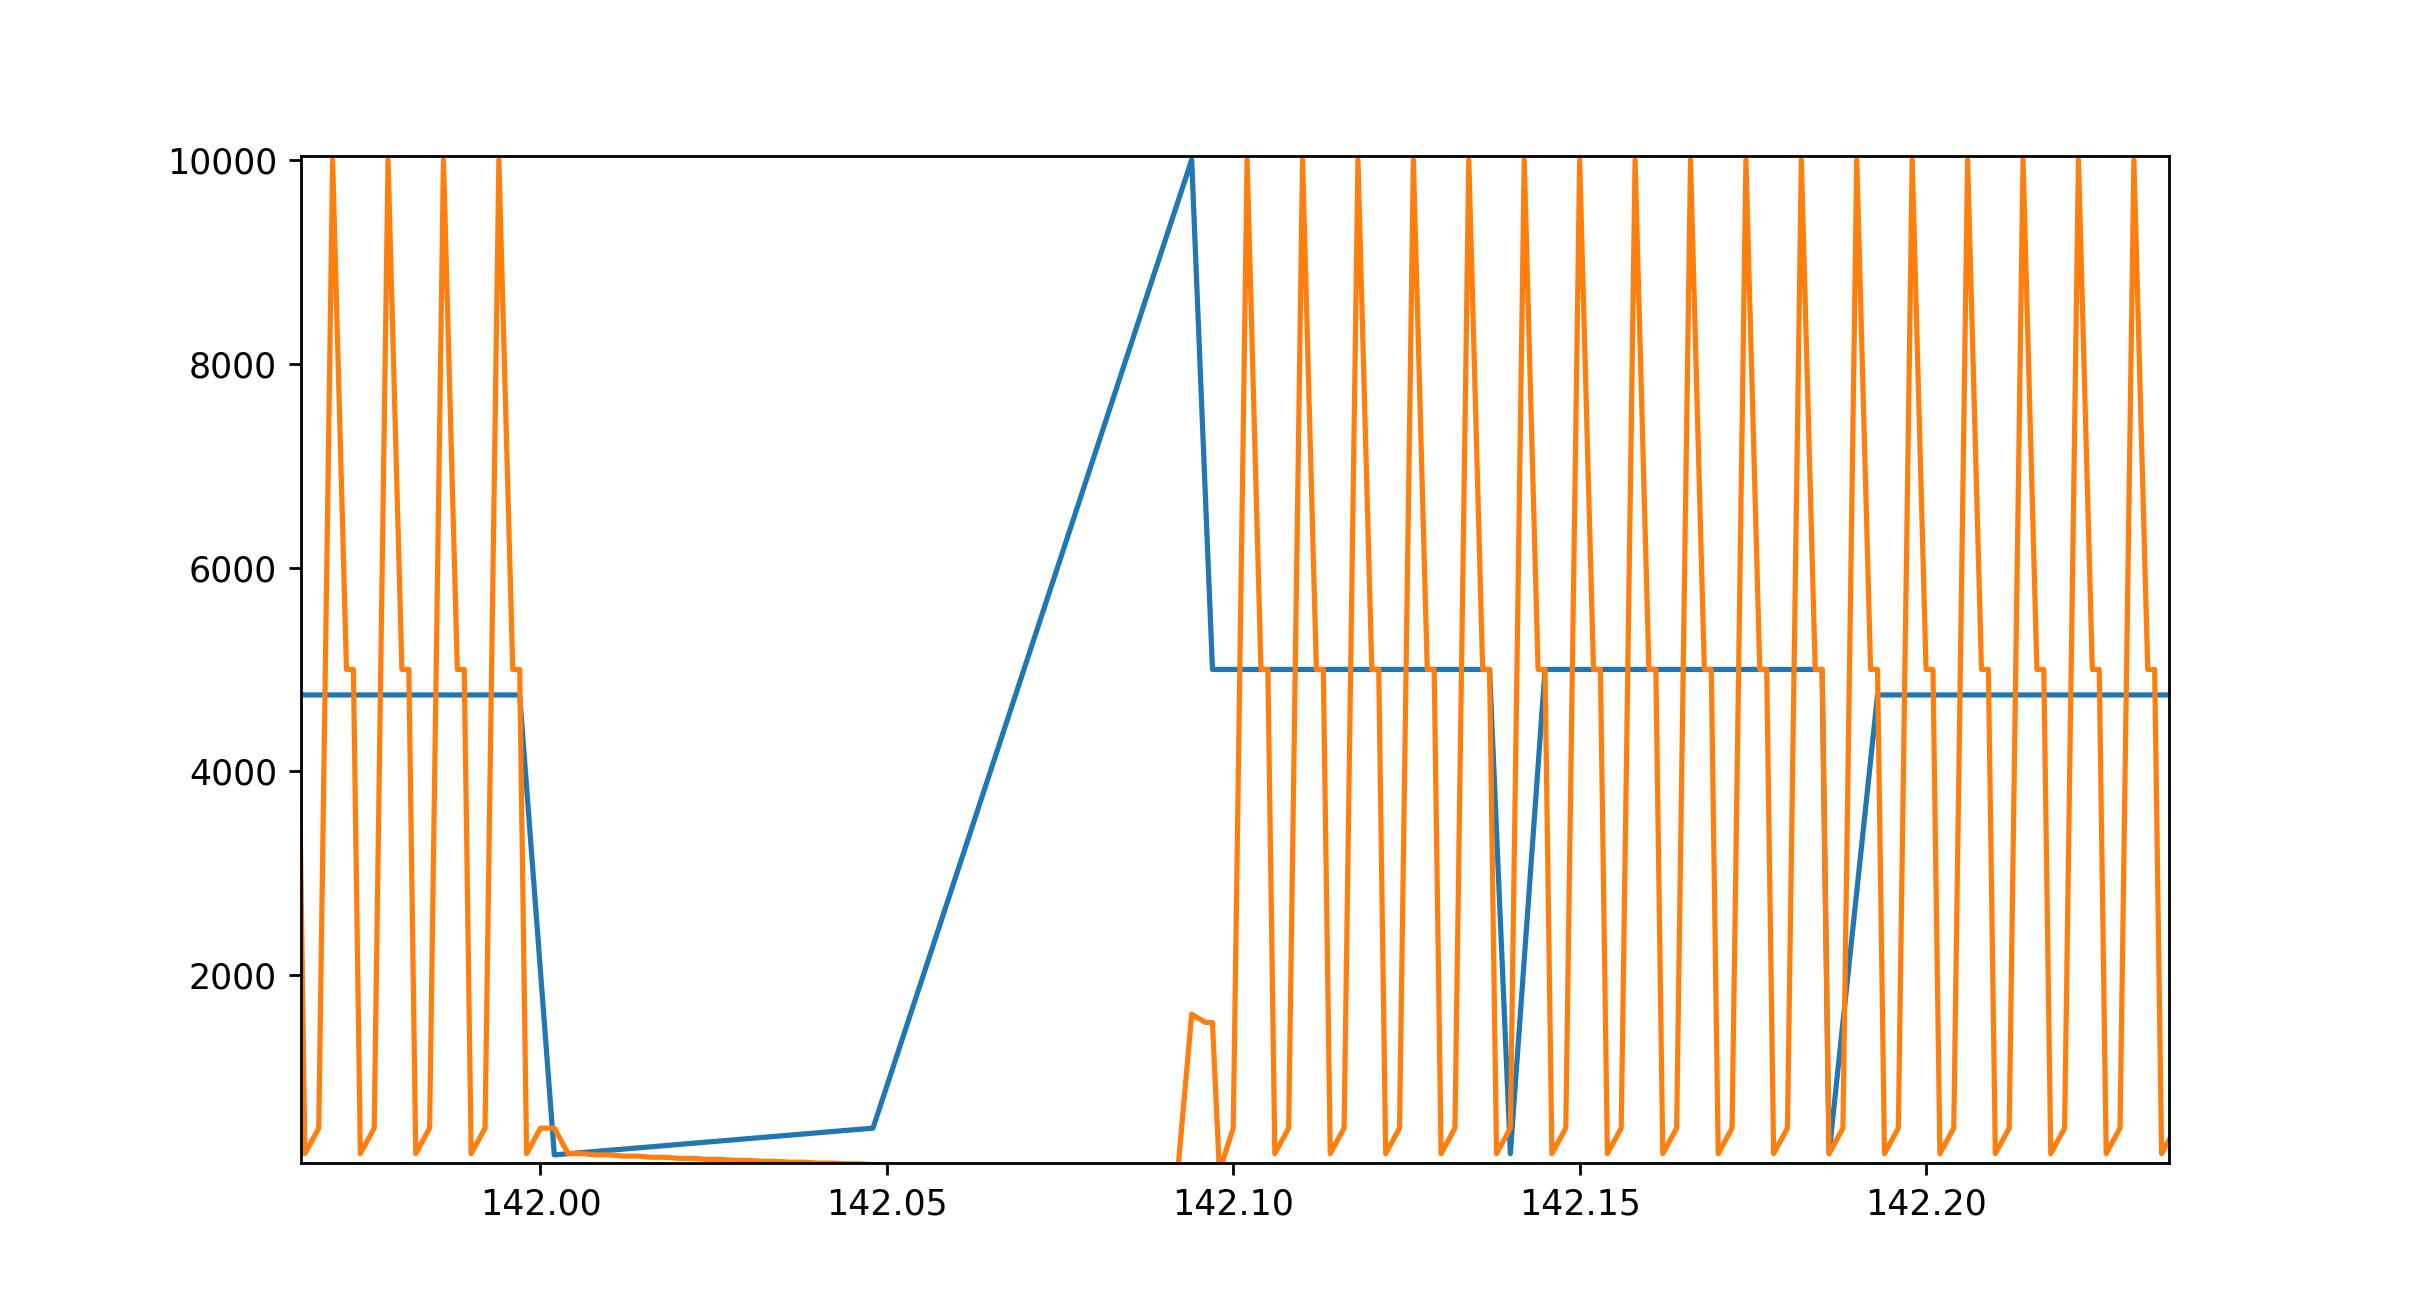

In [23]:
# needs  $ conda install -c conda-forge bqplot
%gui osx
%matplotlib notebook
import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt

import bqplot.pyplot as bplt
from bqplot import LinearScale
from bqplot import Axis

def plot_rate(flow,start=0,stop=-1):
    x,y = zip(*flow.receive_data)
    plot = plt.plot(x,y,label=flow.name)
    return plot

def plot_congestion(flow,start=0,stop=-1):
    x,y = zip(*flow.congestion_data)
    plot = plt.plot(x,y,label=flow.name)
    return plot

print flow1.name
plot1 = plot_rate(flow1)
plot2 = plot_rate(flow2)
plt.show()
#plot = plot_congestion(flow1)
#plt.show()




Flow data can be directly used from python. The following shows the flow2's initial ramp up. Each entry in the flow2.receive_data is two values, simulated time (in second) and rate in Mbps.

In [70]:
for tick in range(0,10000):
    print flow1.receive_data[tick]

[0.0, 0]
[0.092, 0]
[0.137, 0]
[0.138, 0]
[0.184, 500]
[0.23, 10000]
[0.233, 5000.0]
[0.241, 5000.0]
[0.249, 5000.0]
[0.257, 5000.0]
[0.265, 5000.0]
[0.273, 5000.0]
[0.276, 250.0]
[0.281, 5000.0]
[0.289, 5000.0]
[0.297, 5000.0]
[0.305, 5000.0]
[0.313, 5000.0]
[0.321, 5000.0]
[0.322, 250.0]
[0.329, 4750.0]
[0.337, 4750.0]
[0.345, 4750.0]
[0.353, 4750.0]
[0.361, 4750.0]
[0.368, 4750.0]
[0.369, 4750.0]
[0.377, 4750.0]
[0.385, 4750.0]
[0.393, 4750.0]
[0.401, 4750.0]
[0.409, 4750.0]
[0.414, 237.5]
[0.46, 500]
[0.506, 10000]
[0.509, 5000.0]
[0.517, 5000.0]
[0.525, 5000.0]
[0.533, 5000.0]
[0.541, 5000.0]
[0.549, 5000.0]
[0.552, 250.0]
[0.557, 5000.0]
[0.565, 5000.0]
[0.573, 5000.0]
[0.581, 5000.0]
[0.589, 5000.0]
[0.597, 5000.0]
[0.598, 250.0]
[0.605, 4750.0]
[0.613, 4750.0]
[0.621, 4750.0]
[0.629, 4750.0]
[0.637, 4750.0]
[0.644, 4750.0]
[0.645, 4750.0]
[0.653, 4750.0]
[0.661, 4750.0]
[0.669, 4750.0]
[0.677, 4750.0]
[0.685, 4750.0]
[0.69, 237.5]
[0.736, 500]
[0.782, 10000]
[0.785, 5000.0]
[0.

[17.977, 5000.0]
[17.985, 5000.0]
[17.986, 250.0]
[17.993, 4750.0]
[18.001, 4750.0]
[18.009, 4750.0]
[18.017, 4750.0]
[18.025, 4750.0]
[18.032, 4750.0]
[18.033, 4750.0]
[18.041, 4750.0]
[18.049, 4750.0]
[18.057, 4750.0]
[18.065, 4750.0]
[18.073, 4750.0]
[18.078, 237.5]
[18.124, 500]
[18.17, 10000]
[18.173, 5000.0]
[18.181, 5000.0]
[18.189, 5000.0]
[18.197, 5000.0]
[18.205, 5000.0]
[18.213, 5000.0]
[18.216, 250.0]
[18.221, 5000.0]
[18.229, 5000.0]
[18.237, 5000.0]
[18.245, 5000.0]
[18.253, 5000.0]
[18.261, 5000.0]
[18.262, 250.0]
[18.269, 4750.0]
[18.277, 4750.0]
[18.285, 4750.0]
[18.293, 4750.0]
[18.301, 4750.0]
[18.308, 4750.0]
[18.309, 4750.0]
[18.317, 4750.0]
[18.325, 4750.0]
[18.333, 4750.0]
[18.341, 4750.0]
[18.349, 4750.0]
[18.354, 237.5]
[18.4, 500]
[18.446, 10000]
[18.449, 5000.0]
[18.457, 5000.0]
[18.465, 5000.0]
[18.473, 5000.0]
[18.481, 5000.0]
[18.489, 5000.0]
[18.492, 250.0]
[18.497, 5000.0]
[18.505, 5000.0]
[18.513, 5000.0]
[18.521, 5000.0]
[18.529, 5000.0]
[18.537, 5000.

[44.749, 5000.0]
[44.757, 5000.0]
[44.758, 250.0]
[44.765, 4750.0]
[44.773, 4750.0]
[44.781, 4750.0]
[44.789, 4750.0]
[44.797, 4750.0]
[44.804, 4750.0]
[44.805, 4750.0]
[44.813, 4750.0]
[44.821, 4750.0]
[44.829, 4750.0]
[44.837, 4750.0]
[44.845, 4750.0]
[44.85, 237.5]
[44.896, 500]
[44.942, 10000]
[44.945, 5000.0]
[44.953, 5000.0]
[44.961, 5000.0]
[44.969, 5000.0]
[44.977, 5000.0]
[44.985, 5000.0]
[44.988, 250.0]
[44.993, 5000.0]
[45.001, 5000.0]
[45.009, 5000.0]
[45.017, 5000.0]
[45.025, 5000.0]
[45.033, 5000.0]
[45.034, 250.0]
[45.041, 4750.0]
[45.049, 4750.0]
[45.057, 4750.0]
[45.065, 4750.0]
[45.073, 4750.0]
[45.08, 4750.0]
[45.081, 4750.0]
[45.089, 4750.0]
[45.097, 4750.0]
[45.105, 4750.0]
[45.113, 4750.0]
[45.121, 4750.0]
[45.126, 237.5]
[45.172, 500]
[45.218, 10000]
[45.221, 5000.0]
[45.229, 5000.0]
[45.237, 5000.0]
[45.245, 5000.0]
[45.253, 5000.0]
[45.261, 5000.0]
[45.264, 250.0]
[45.269, 5000.0]
[45.277, 5000.0]
[45.285, 5000.0]
[45.293, 5000.0]
[45.301, 5000.0]
[45.309, 5000

[71.993, 5000.0]
[72.001, 5000.0]
[72.009, 5000.0]
[72.017, 5000.0]
[72.025, 5000.0]
[72.033, 5000.0]
[72.036, 250.0]
[72.041, 5000.0]
[72.049, 5000.0]
[72.057, 5000.0]
[72.065, 5000.0]
[72.073, 5000.0]
[72.081, 5000.0]
[72.082, 250.0]
[72.089, 4750.0]
[72.097, 4750.0]
[72.105, 4750.0]
[72.113, 4750.0]
[72.121, 4750.0]
[72.128, 4750.0]
[72.129, 4750.0]
[72.137, 4750.0]
[72.145, 4750.0]
[72.153, 4750.0]
[72.161, 4750.0]
[72.169, 4750.0]
[72.174, 237.5]
[72.22, 500]
[72.266, 10000]
[72.269, 5000.0]
[72.277, 5000.0]
[72.285, 5000.0]
[72.293, 5000.0]
[72.301, 5000.0]
[72.309, 5000.0]
[72.312, 250.0]
[72.317, 5000.0]
[72.325, 5000.0]
[72.333, 5000.0]
[72.341, 5000.0]
[72.349, 5000.0]
[72.357, 5000.0]
[72.358, 250.0]
[72.365, 4750.0]
[72.373, 4750.0]
[72.381, 4750.0]
[72.389, 4750.0]
[72.397, 4750.0]
[72.404, 4750.0]
[72.405, 4750.0]
[72.413, 4750.0]
[72.421, 4750.0]
[72.429, 4750.0]
[72.437, 4750.0]
[72.445, 4750.0]
[72.45, 237.5]
[72.496, 500]
[72.542, 10000]
[72.545, 5000.0]
[72.553, 5000

In [69]:
for t,r in flow2.receive_data:
    if r < 500 and t > 5:
        print t,r

5.006 250.0
5.014 250.0
5.022 250.0
5.03 250.0
5.038 250.0
5.046 250.0
5.054 250.0
5.062 250.0
5.07 250.0
5.078 250.0
5.086 250.0
5.094 250.0
5.102 250.0
5.108 250.0
5.11 250.0
5.112 237.5
5.114 237.5
5.116 225.625
5.118 225.625
5.12 214.34375
5.122 214.34375
5.124 203.6265625
5.126 203.6265625
5.128 193.445234375
5.13 193.445234375
5.132 183.772972656
5.134 183.772972656
5.136 174.584324023
5.138 174.584324023
5.14 165.855107822
5.142 165.855107822
5.144 157.562352431
5.146 157.562352431
5.148 149.68423481
5.15 149.68423481
5.152 142.200023069
5.154 142.200023069
5.156 135.090021916
5.158 135.090021916
5.16 128.33552082
5.162 128.33552082
5.164 121.918744779
5.166 121.918744779
5.168 115.82280754
5.17 115.82280754
5.172 110.031667163
5.174 110.031667163
5.176 104.530083805
5.178 104.530083805
5.18 99.3035796146
5.182 99.3035796146
5.184 94.3384006338
5.186 94.3384006338
5.188 89.6214806021
5.19 89.6214806021
5.192 85.140406572
5.194 85.140406572
5.196 80.8833862434
5.202 76.8392169313

8.736 149.68423481
8.738 149.68423481
8.74 142.200023069
8.742 142.200023069
8.744 135.090021916
8.746 135.090021916
8.748 128.33552082
8.75 128.33552082
8.752 121.918744779
8.754 121.918744779
8.756 115.82280754
8.758 115.82280754
8.76 110.031667163
8.762 110.031667163
8.764 104.530083805
8.766 104.530083805
8.768 99.3035796146
8.77 99.3035796146
8.772 94.3384006338
8.774 94.3384006338
8.776 89.6214806021
8.778 89.6214806021
8.78 85.140406572
8.782 85.140406572
8.784 80.8833862434
8.79 76.8392169313
8.798 250.0
8.806 250.0
8.814 250.0
8.822 250.0
8.83 250.0
8.838 250.0
8.846 250.0
8.854 250.0
8.862 250.0
8.87 250.0
8.878 250.0
8.886 250.0
8.894 250.0
8.902 250.0
8.91 250.0
8.918 250.0
8.926 250.0
8.934 250.0
8.942 250.0
8.95 250.0
8.958 250.0
8.966 250.0
8.972 250.0
8.974 250.0
8.976 237.5
8.978 237.5
8.98 225.625
8.982 225.625
8.984 214.34375
8.986 214.34375
8.988 203.6265625
8.99 203.6265625
8.992 193.445234375
8.994 193.445234375
8.996 183.772972656
8.998 183.772972656
9.0 174.5843

14.528 157.562352431
14.53 157.562352431
14.532 149.68423481
14.534 149.68423481
14.536 142.200023069
14.538 142.200023069
14.54 135.090021916
14.542 135.090021916
14.544 128.33552082
14.546 128.33552082
14.548 121.918744779
14.55 121.918744779
14.552 115.82280754
14.554 115.82280754
14.556 110.031667163
14.558 110.031667163
14.56 104.530083805
14.562 104.530083805
14.564 99.3035796146
14.566 99.3035796146
14.568 94.3384006338
14.57 94.3384006338
14.572 89.6214806021
14.574 89.6214806021
14.576 85.140406572
14.578 85.140406572
14.58 80.8833862434
14.586 76.8392169313
14.594 250.0
14.602 250.0
14.61 250.0
14.618 250.0
14.626 250.0
14.634 250.0
14.642 250.0
14.65 250.0
14.658 250.0
14.666 250.0
14.674 250.0
14.682 250.0
14.69 250.0
14.698 250.0
14.706 250.0
14.714 250.0
14.722 250.0
14.73 250.0
14.738 250.0
14.746 250.0
14.754 250.0
14.762 250.0
14.768 250.0
14.77 250.0
14.772 237.5
14.774 237.5
14.776 225.625
14.778 225.625
14.78 214.34375
14.782 214.34375
14.784 203.6265625
14.786 203.

16.766 110.031667163
16.768 104.530083805
16.77 104.530083805
16.772 99.3035796146
16.774 99.3035796146
16.776 94.3384006338
16.778 94.3384006338
16.78 89.6214806021
16.782 89.6214806021
16.784 85.140406572
16.786 85.140406572
16.788 80.8833862434
16.794 76.8392169313
16.802 250.0
16.81 250.0
16.818 250.0
16.826 250.0
16.834 250.0
16.842 250.0
16.85 250.0
16.858 250.0
16.866 250.0
16.874 250.0
16.882 250.0
16.89 250.0
16.898 250.0
16.906 250.0
16.914 250.0
16.922 250.0
16.93 250.0
16.938 250.0
16.946 250.0
16.954 250.0
16.962 250.0
16.97 250.0
16.976 250.0
16.978 250.0
16.98 237.5
16.982 237.5
16.984 225.625
16.986 225.625
16.988 214.34375
16.99 214.34375
16.992 203.6265625
16.994 203.6265625
16.996 193.445234375
16.998 193.445234375
17.0 183.772972656
17.002 183.772972656
17.004 174.584324023
17.006 174.584324023
17.008 165.855107822
17.01 165.855107822
17.012 157.562352431
17.014 157.562352431
17.016 149.68423481
17.018 149.68423481
17.02 142.200023069
17.022 142.200023069
17.024 135

22.846 99.3035796146
22.848 94.3384006338
22.85 94.3384006338
22.852 89.6214806021
22.854 89.6214806021
22.856 85.140406572
22.858 85.140406572
22.86 80.8833862434
22.866 76.8392169313
22.874 250.0
22.882 250.0
22.89 250.0
22.898 250.0
22.906 250.0
22.914 250.0
22.922 250.0
22.93 250.0
22.938 250.0
22.946 250.0
22.954 250.0
22.962 250.0
22.97 250.0
22.978 250.0
22.986 250.0
22.994 250.0
23.002 250.0
23.01 250.0
23.018 250.0
23.026 250.0
23.034 250.0
23.042 250.0
23.048 250.0
23.05 250.0
23.052 237.5
23.054 237.5
23.056 225.625
23.058 225.625
23.06 214.34375
23.062 214.34375
23.064 203.6265625
23.066 203.6265625
23.068 193.445234375
23.07 193.445234375
23.072 183.772972656
23.074 183.772972656
23.076 174.584324023
23.078 174.584324023
23.08 165.855107822
23.082 165.855107822
23.084 157.562352431
23.086 157.562352431
23.088 149.68423481
23.09 149.68423481
23.092 142.200023069
23.094 142.200023069
23.096 135.090021916
23.098 135.090021916
23.1 128.33552082
23.102 128.33552082
23.104 121.9

29.058 250.0
29.066 250.0
29.074 250.0
29.082 250.0
29.09 250.0
29.098 250.0
29.106 250.0
29.114 250.0
29.12 250.0
29.122 250.0
29.124 237.5
29.126 237.5
29.128 225.625
29.13 225.625
29.132 214.34375
29.134 214.34375
29.136 203.6265625
29.138 203.6265625
29.14 193.445234375
29.142 193.445234375
29.144 183.772972656
29.146 183.772972656
29.148 174.584324023
29.15 174.584324023
29.152 165.855107822
29.154 165.855107822
29.156 157.562352431
29.158 157.562352431
29.16 149.68423481
29.162 149.68423481
29.164 142.200023069
29.166 142.200023069
29.168 135.090021916
29.17 135.090021916
29.172 128.33552082
29.174 128.33552082
29.176 121.918744779
29.178 121.918744779
29.18 115.82280754
29.182 115.82280754
29.184 110.031667163
29.186 110.031667163
29.188 104.530083805
29.19 104.530083805
29.192 99.3035796146
29.194 99.3035796146
29.196 94.3384006338
29.198 94.3384006338
29.2 89.6214806021
29.202 89.6214806021
29.204 85.140406572
29.206 85.140406572
29.208 80.8833862434
29.214 76.8392169313
29.22

35.206 214.34375
35.208 203.6265625
35.21 203.6265625
35.212 193.445234375
35.214 193.445234375
35.216 183.772972656
35.218 183.772972656
35.22 174.584324023
35.222 174.584324023
35.224 165.855107822
35.226 165.855107822
35.228 157.562352431
35.23 157.562352431
35.232 149.68423481
35.234 149.68423481
35.236 142.200023069
35.238 142.200023069
35.24 135.090021916
35.242 135.090021916
35.244 128.33552082
35.246 128.33552082
35.248 121.918744779
35.25 121.918744779
35.252 115.82280754
35.254 115.82280754
35.256 110.031667163
35.258 110.031667163
35.26 104.530083805
35.262 104.530083805
35.264 99.3035796146
35.266 99.3035796146
35.268 94.3384006338
35.27 94.3384006338
35.272 89.6214806021
35.274 89.6214806021
35.276 85.140406572
35.278 85.140406572
35.28 80.8833862434
35.286 76.8392169313
35.294 250.0
35.302 250.0
35.31 250.0
35.318 250.0
35.326 250.0
35.334 250.0
35.342 250.0
35.35 250.0
35.358 250.0
35.366 250.0
35.374 250.0
35.382 250.0
35.39 250.0
35.398 250.0
35.406 250.0
35.414 250.0


41.242 250.0
41.25 250.0
41.258 250.0
41.264 250.0
41.266 250.0
41.268 237.5
41.27 237.5
41.272 225.625
41.274 225.625
41.276 214.34375
41.278 214.34375
41.28 203.6265625
41.282 203.6265625
41.284 193.445234375
41.286 193.445234375
41.288 183.772972656
41.29 183.772972656
41.292 174.584324023
41.294 174.584324023
41.296 165.855107822
41.298 165.855107822
41.3 157.562352431
41.302 157.562352431
41.304 149.68423481
41.306 149.68423481
41.308 142.200023069
41.31 142.200023069
41.312 135.090021916
41.314 135.090021916
41.316 128.33552082
41.318 128.33552082
41.32 121.918744779
41.322 121.918744779
41.324 115.82280754
41.326 115.82280754
41.328 110.031667163
41.33 110.031667163
41.332 104.530083805
41.334 104.530083805
41.336 99.3035796146
41.338 99.3035796146
41.34 94.3384006338
41.342 94.3384006338
41.344 89.6214806021
41.346 89.6214806021
41.348 85.140406572
41.35 85.140406572
41.352 80.8833862434
41.358 76.8392169313
41.366 250.0
41.374 250.0
41.382 250.0
41.39 250.0
41.398 250.0
41.406

47.21 250.0
47.218 250.0
47.226 250.0
47.234 250.0
47.242 250.0
47.25 250.0
47.258 250.0
47.266 250.0
47.274 250.0
47.282 250.0
47.29 250.0
47.298 250.0
47.306 250.0
47.314 250.0
47.322 250.0
47.33 250.0
47.336 250.0
47.338 250.0
47.34 237.5
47.342 237.5
47.344 225.625
47.346 225.625
47.348 214.34375
47.35 214.34375
47.352 203.6265625
47.354 203.6265625
47.356 193.445234375
47.358 193.445234375
47.36 183.772972656
47.362 183.772972656
47.364 174.584324023
47.366 174.584324023
47.368 165.855107822
47.37 165.855107822
47.372 157.562352431
47.374 157.562352431
47.376 149.68423481
47.378 149.68423481
47.38 142.200023069
47.382 142.200023069
47.384 135.090021916
47.386 135.090021916
47.388 128.33552082
47.39 128.33552082
47.392 121.918744779
47.394 121.918744779
47.396 115.82280754
47.398 115.82280754
47.4 110.031667163
47.402 110.031667163
47.404 104.530083805
47.406 104.530083805
47.408 99.3035796146
47.41 99.3035796146
47.412 94.3384006338
47.414 94.3384006338
47.416 89.6214806021
47.418

53.15 203.6265625
53.152 193.445234375
53.154 193.445234375
53.156 183.772972656
53.158 183.772972656
53.16 174.584324023
53.162 174.584324023
53.164 165.855107822
53.166 165.855107822
53.168 157.562352431
53.17 157.562352431
53.172 149.68423481
53.174 149.68423481
53.176 142.200023069
53.178 142.200023069
53.18 135.090021916
53.182 135.090021916
53.184 128.33552082
53.186 128.33552082
53.188 121.918744779
53.19 121.918744779
53.192 115.82280754
53.194 115.82280754
53.196 110.031667163
53.198 110.031667163
53.2 104.530083805
53.202 104.530083805
53.204 99.3035796146
53.206 99.3035796146
53.208 94.3384006338
53.21 94.3384006338
53.212 89.6214806021
53.214 89.6214806021
53.216 85.140406572
53.218 85.140406572
53.22 80.8833862434
53.226 76.8392169313
53.234 250.0
53.242 250.0
53.25 250.0
53.258 250.0
53.266 250.0
53.274 250.0
53.282 250.0
53.29 250.0
53.298 250.0
53.306 250.0
53.314 250.0
53.322 250.0
53.33 250.0
53.338 250.0
53.346 250.0
53.354 250.0
53.362 250.0
53.37 250.0
53.378 250.0

59.226 193.445234375
59.228 183.772972656
59.23 183.772972656
59.232 174.584324023
59.234 174.584324023
59.236 165.855107822
59.238 165.855107822
59.24 157.562352431
59.242 157.562352431
59.244 149.68423481
59.246 149.68423481
59.248 142.200023069
59.25 142.200023069
59.252 135.090021916
59.254 135.090021916
59.256 128.33552082
59.258 128.33552082
59.26 121.918744779
59.262 121.918744779
59.264 115.82280754
59.266 115.82280754
59.268 110.031667163
59.27 110.031667163
59.272 104.530083805
59.274 104.530083805
59.276 99.3035796146
59.278 99.3035796146
59.28 94.3384006338
59.282 94.3384006338
59.284 89.6214806021
59.286 89.6214806021
59.288 85.140406572
59.29 85.140406572
59.292 80.8833862434
59.298 76.8392169313
59.306 250.0
59.314 250.0
59.322 250.0
59.33 250.0
59.338 250.0
59.346 250.0
59.354 250.0
59.362 250.0
59.37 250.0
59.378 250.0
59.386 250.0
59.394 250.0
59.402 250.0
59.41 250.0
59.418 250.0
59.426 250.0
59.434 250.0
59.442 250.0
59.45 250.0
59.458 250.0
59.466 250.0
59.474 250.

65.34 110.031667163
65.342 110.031667163
65.344 104.530083805
65.346 104.530083805
65.348 99.3035796146
65.35 99.3035796146
65.352 94.3384006338
65.354 94.3384006338
65.356 89.6214806021
65.358 89.6214806021
65.36 85.140406572
65.362 85.140406572
65.364 80.8833862434
65.37 76.8392169313
65.378 250.0
65.386 250.0
65.394 250.0
65.402 250.0
65.41 250.0
65.418 250.0
65.426 250.0
65.434 250.0
65.442 250.0
65.45 250.0
65.458 250.0
65.466 250.0
65.474 250.0
65.482 250.0
65.49 250.0
65.498 250.0
65.506 250.0
65.514 250.0
65.522 250.0
65.53 250.0
65.538 250.0
65.546 250.0
65.552 250.0
65.554 250.0
65.556 237.5
65.558 237.5
65.56 225.625
65.562 225.625
65.564 214.34375
65.566 214.34375
65.568 203.6265625
65.57 203.6265625
65.572 193.445234375
65.574 193.445234375
65.576 183.772972656
65.578 183.772972656
65.58 174.584324023
65.582 174.584324023
65.584 165.855107822
65.586 165.855107822
65.588 157.562352431
65.59 157.562352431
65.592 149.68423481
65.594 149.68423481
65.596 142.200023069
65.598 14

71.402 128.33552082
71.404 121.918744779
71.406 121.918744779
71.408 115.82280754
71.41 115.82280754
71.412 110.031667163
71.414 110.031667163
71.416 104.530083805
71.418 104.530083805
71.42 99.3035796146
71.422 99.3035796146
71.424 94.3384006338
71.426 94.3384006338
71.428 89.6214806021
71.43 89.6214806021
71.432 85.140406572
71.434 85.140406572
71.436 80.8833862434
71.442 76.8392169313
71.45 250.0
71.458 250.0
71.466 250.0
71.474 250.0
71.482 250.0
71.49 250.0
71.498 250.0
71.506 250.0
71.514 250.0
71.522 250.0
71.53 250.0
71.538 250.0
71.546 250.0
71.554 250.0
71.562 250.0
71.57 250.0
71.578 250.0
71.586 250.0
71.594 250.0
71.602 250.0
71.61 250.0
71.618 250.0
71.624 250.0
71.626 250.0
71.628 237.5
71.63 237.5
71.632 225.625
71.634 225.625
71.636 214.34375
71.638 214.34375
71.64 203.6265625
71.642 203.6265625
71.644 193.445234375
71.646 193.445234375
71.648 183.772972656
71.65 183.772972656
71.652 174.584324023
71.654 174.584324023
71.656 165.855107822
71.658 165.855107822
71.66 157

76.666 99.3035796146
76.668 94.3384006338
76.67 94.3384006338
76.672 89.6214806021
76.674 89.6214806021
76.676 85.140406572
76.678 85.140406572
76.68 80.8833862434
76.686 76.8392169313
76.694 250.0
76.702 250.0
76.71 250.0
76.718 250.0
76.726 250.0
76.734 250.0
76.742 250.0
76.75 250.0
76.758 250.0
76.766 250.0
76.774 250.0
76.782 250.0
76.79 250.0
76.798 250.0
76.806 250.0
76.814 250.0
76.822 250.0
76.83 250.0
76.838 250.0
76.846 250.0
76.854 250.0
76.862 250.0
76.868 250.0
76.87 250.0
76.872 237.5
76.874 237.5
76.876 225.625
76.878 225.625
76.88 214.34375
76.882 214.34375
76.884 203.6265625
76.886 203.6265625
76.888 193.445234375
76.89 193.445234375
76.892 183.772972656
76.894 183.772972656
76.896 174.584324023
76.898 174.584324023
76.9 165.855107822
76.902 165.855107822
76.904 157.562352431
76.906 157.562352431
76.908 149.68423481
76.91 149.68423481
76.912 142.200023069
76.914 142.200023069
76.916 135.090021916
76.918 135.090021916
76.92 128.33552082
76.922 128.33552082
76.924 121.9

81.606 142.200023069
81.608 135.090021916
81.61 135.090021916
81.612 128.33552082
81.614 128.33552082
81.616 121.918744779
81.618 121.918744779
81.62 115.82280754
81.622 115.82280754
81.624 110.031667163
81.626 110.031667163
81.628 104.530083805
81.63 104.530083805
81.632 99.3035796146
81.634 99.3035796146
81.636 94.3384006338
81.638 94.3384006338
81.64 89.6214806021
81.642 89.6214806021
81.644 85.140406572
81.646 85.140406572
81.648 80.8833862434
81.654 76.8392169313
81.662 250.0
81.67 250.0
81.678 250.0
81.686 250.0
81.694 250.0
81.702 250.0
81.71 250.0
81.718 250.0
81.726 250.0
81.734 250.0
81.742 250.0
81.75 250.0
81.758 250.0
81.766 250.0
81.774 250.0
81.782 250.0
81.79 250.0
81.798 250.0
81.806 250.0
81.814 250.0
81.822 250.0
81.83 250.0
81.836 250.0
81.838 250.0
81.84 237.5
81.842 237.5
81.844 225.625
81.846 225.625
81.848 214.34375
81.85 214.34375
81.852 203.6265625
81.854 203.6265625
81.856 193.445234375
81.858 193.445234375
81.86 183.772972656
81.862 183.772972656
81.864 174.

87.278 250.0
87.286 250.0
87.294 250.0
87.302 250.0
87.31 250.0
87.318 250.0
87.326 250.0
87.334 250.0
87.342 250.0
87.35 250.0
87.356 250.0
87.358 250.0
87.36 237.5
87.362 237.5
87.364 225.625
87.366 225.625
87.368 214.34375
87.37 214.34375
87.372 203.6265625
87.374 203.6265625
87.376 193.445234375
87.378 193.445234375
87.38 183.772972656
87.382 183.772972656
87.384 174.584324023
87.386 174.584324023
87.388 165.855107822
87.39 165.855107822
87.392 157.562352431
87.394 157.562352431
87.396 149.68423481
87.398 149.68423481
87.4 142.200023069
87.402 142.200023069
87.404 135.090021916
87.406 135.090021916
87.408 128.33552082
87.41 128.33552082
87.412 121.918744779
87.414 121.918744779
87.416 115.82280754
87.418 115.82280754
87.42 110.031667163
87.422 110.031667163
87.424 104.530083805
87.426 104.530083805
87.428 99.3035796146
87.43 99.3035796146
87.432 94.3384006338
87.434 94.3384006338
87.436 89.6214806021
87.438 89.6214806021
87.44 85.140406572
87.442 85.140406572
87.444 80.8833862434
8

93.164 214.34375
93.166 214.34375
93.168 203.6265625
93.17 203.6265625
93.172 193.445234375
93.174 193.445234375
93.176 183.772972656
93.178 183.772972656
93.18 174.584324023
93.182 174.584324023
93.184 165.855107822
93.186 165.855107822
93.188 157.562352431
93.19 157.562352431
93.192 149.68423481
93.194 149.68423481
93.196 142.200023069
93.198 142.200023069
93.2 135.090021916
93.202 135.090021916
93.204 128.33552082
93.206 128.33552082
93.208 121.918744779
93.21 121.918744779
93.212 115.82280754
93.214 115.82280754
93.216 110.031667163
93.218 110.031667163
93.22 104.530083805
93.222 104.530083805
93.224 99.3035796146
93.226 99.3035796146
93.228 94.3384006338
93.23 94.3384006338
93.232 89.6214806021
93.234 89.6214806021
93.236 85.140406572
93.238 85.140406572
93.24 80.8833862434
93.246 76.8392169313
93.254 250.0
93.262 250.0
93.27 250.0
93.278 250.0
93.286 250.0
93.294 250.0
93.302 250.0
93.31 250.0
93.318 250.0
93.326 250.0
93.334 250.0
93.342 250.0
93.35 250.0
93.358 250.0
93.366 250

98.698 183.772972656
98.7 174.584324023
98.702 174.584324023
98.704 165.855107822
98.706 165.855107822
98.708 157.562352431
98.71 157.562352431
98.712 149.68423481
98.714 149.68423481
98.716 142.200023069
98.718 142.200023069
98.72 135.090021916
98.722 135.090021916
98.724 128.33552082
98.726 128.33552082
98.728 121.918744779
98.73 121.918744779
98.732 115.82280754
98.734 115.82280754
98.736 110.031667163
98.738 110.031667163
98.74 104.530083805
98.742 104.530083805
98.744 99.3035796146
98.746 99.3035796146
98.748 94.3384006338
98.75 94.3384006338
98.752 89.6214806021
98.754 89.6214806021
98.756 85.140406572
98.758 85.140406572
98.76 80.8833862434
98.766 76.8392169313
98.774 250.0
98.782 250.0
98.79 250.0
98.798 250.0
98.806 250.0
98.814 250.0
98.822 250.0
98.83 250.0
98.838 250.0
98.846 250.0
98.854 250.0
98.862 250.0
98.87 250.0
98.878 250.0
98.886 250.0
98.894 250.0
98.902 250.0
98.91 250.0
98.918 250.0
98.926 250.0
98.934 250.0
98.942 250.0
98.948 250.0
98.95 250.0
98.952 237.5
98.

103.11 193.445234375
103.112 183.772972656
103.114 183.772972656
103.116 174.584324023
103.118 174.584324023
103.12 165.855107822
103.122 165.855107822
103.124 157.562352431
103.126 157.562352431
103.128 149.68423481
103.13 149.68423481
103.132 142.200023069
103.134 142.200023069
103.136 135.090021916
103.138 135.090021916
103.14 128.33552082
103.142 128.33552082
103.144 121.918744779
103.146 121.918744779
103.148 115.82280754
103.15 115.82280754
103.152 110.031667163
103.154 110.031667163
103.156 104.530083805
103.158 104.530083805
103.16 99.3035796146
103.162 99.3035796146
103.164 94.3384006338
103.166 94.3384006338
103.168 89.6214806021
103.17 89.6214806021
103.172 85.140406572
103.174 85.140406572
103.176 80.8833862434
103.182 76.8392169313
103.19 250.0
103.198 250.0
103.206 250.0
103.214 250.0
103.222 250.0
103.23 250.0
103.238 250.0
103.246 250.0
103.254 250.0
103.262 250.0
103.27 250.0
103.278 250.0
103.286 250.0
103.294 250.0
103.302 250.0
103.31 250.0
103.318 250.0
103.326 250

108.104 135.090021916
108.106 135.090021916
108.108 128.33552082
108.11 128.33552082
108.112 121.918744779
108.114 121.918744779
108.116 115.82280754
108.118 115.82280754
108.12 110.031667163
108.122 110.031667163
108.124 104.530083805
108.126 104.530083805
108.128 99.3035796146
108.13 99.3035796146
108.132 94.3384006338
108.134 94.3384006338
108.136 89.6214806021
108.138 89.6214806021
108.14 85.140406572
108.142 85.140406572
108.144 80.8833862434
108.15 76.8392169313
108.158 250.0
108.166 250.0
108.174 250.0
108.182 250.0
108.19 250.0
108.198 250.0
108.206 250.0
108.214 250.0
108.222 250.0
108.23 250.0
108.238 250.0
108.246 250.0
108.254 250.0
108.262 250.0
108.27 250.0
108.278 250.0
108.286 250.0
108.294 250.0
108.302 250.0
108.31 250.0
108.318 250.0
108.326 250.0
108.332 250.0
108.334 250.0
108.336 237.5
108.338 237.5
108.34 225.625
108.342 225.625
108.344 214.34375
108.346 214.34375
108.348 203.6265625
108.35 203.6265625
108.352 193.445234375
108.354 193.445234375
108.356 183.77297

113.64 110.031667163
113.642 110.031667163
113.644 104.530083805
113.646 104.530083805
113.648 99.3035796146
113.65 99.3035796146
113.652 94.3384006338
113.654 94.3384006338
113.656 89.6214806021
113.658 89.6214806021
113.66 85.140406572
113.662 85.140406572
113.664 80.8833862434
113.67 76.8392169313
113.678 250.0
113.686 250.0
113.694 250.0
113.702 250.0
113.71 250.0
113.718 250.0
113.726 250.0
113.734 250.0
113.742 250.0
113.75 250.0
113.758 250.0
113.766 250.0
113.774 250.0
113.782 250.0
113.79 250.0
113.798 250.0
113.806 250.0
113.814 250.0
113.822 250.0
113.83 250.0
113.838 250.0
113.846 250.0
113.852 250.0
113.854 250.0
113.856 237.5
113.858 237.5
113.86 225.625
113.862 225.625
113.864 214.34375
113.866 214.34375
113.868 203.6265625
113.87 203.6265625
113.872 193.445234375
113.874 193.445234375
113.876 183.772972656
113.878 183.772972656
113.88 174.584324023
113.882 174.584324023
113.884 165.855107822
113.886 165.855107822
113.888 157.562352431
113.89 157.562352431
113.892 149.68

119.384 214.34375
119.386 214.34375
119.388 203.6265625
119.39 203.6265625
119.392 193.445234375
119.394 193.445234375
119.396 183.772972656
119.398 183.772972656
119.4 174.584324023
119.402 174.584324023
119.404 165.855107822
119.406 165.855107822
119.408 157.562352431
119.41 157.562352431
119.412 149.68423481
119.414 149.68423481
119.416 142.200023069
119.418 142.200023069
119.42 135.090021916
119.422 135.090021916
119.424 128.33552082
119.426 128.33552082
119.428 121.918744779
119.43 121.918744779
119.432 115.82280754
119.434 115.82280754
119.436 110.031667163
119.438 110.031667163
119.44 104.530083805
119.442 104.530083805
119.444 99.3035796146
119.446 99.3035796146
119.448 94.3384006338
119.45 94.3384006338
119.452 89.6214806021
119.454 89.6214806021
119.456 85.140406572
119.458 85.140406572
119.46 80.8833862434
119.466 76.8392169313
119.474 250.0
119.482 250.0
119.49 250.0
119.498 250.0
119.506 250.0
119.514 250.0
119.522 250.0
119.53 250.0
119.538 250.0
119.546 250.0
119.554 250

125.446 250.0
125.448 237.5
125.45 237.5
125.452 225.625
125.454 225.625
125.456 214.34375
125.458 214.34375
125.46 203.6265625
125.462 203.6265625
125.464 193.445234375
125.466 193.445234375
125.468 183.772972656
125.47 183.772972656
125.472 174.584324023
125.474 174.584324023
125.476 165.855107822
125.478 165.855107822
125.48 157.562352431
125.482 157.562352431
125.484 149.68423481
125.486 149.68423481
125.488 142.200023069
125.49 142.200023069
125.492 135.090021916
125.494 135.090021916
125.496 128.33552082
125.498 128.33552082
125.5 121.918744779
125.502 121.918744779
125.504 115.82280754
125.506 115.82280754
125.508 110.031667163
125.51 110.031667163
125.512 104.530083805
125.514 104.530083805
125.516 99.3035796146
125.518 99.3035796146
125.52 94.3384006338
125.522 94.3384006338
125.524 89.6214806021
125.526 89.6214806021
125.528 85.140406572
125.53 85.140406572
125.532 80.8833862434
125.538 76.8392169313
125.546 250.0
125.554 250.0
125.562 250.0
125.57 250.0
125.578 250.0
125.586

131.524 225.625
131.526 225.625
131.528 214.34375
131.53 214.34375
131.532 203.6265625
131.534 203.6265625
131.536 193.445234375
131.538 193.445234375
131.54 183.772972656
131.542 183.772972656
131.544 174.584324023
131.546 174.584324023
131.548 165.855107822
131.55 165.855107822
131.552 157.562352431
131.554 157.562352431
131.556 149.68423481
131.558 149.68423481
131.56 142.200023069
131.562 142.200023069
131.564 135.090021916
131.566 135.090021916
131.568 128.33552082
131.57 128.33552082
131.572 121.918744779
131.574 121.918744779
131.576 115.82280754
131.578 115.82280754
131.58 110.031667163
131.582 110.031667163
131.584 104.530083805
131.586 104.530083805
131.588 99.3035796146
131.59 99.3035796146
131.592 94.3384006338
131.594 94.3384006338
131.596 89.6214806021
131.598 89.6214806021
131.6 85.140406572
131.602 85.140406572
131.604 80.8833862434
131.61 76.8392169313
131.618 250.0
131.626 250.0
131.634 250.0
131.642 250.0
131.65 250.0
131.658 250.0
131.666 250.0
131.674 250.0
131.682

137.478 250.0
137.486 250.0
137.494 250.0
137.502 250.0
137.51 250.0
137.518 250.0
137.526 250.0
137.534 250.0
137.542 250.0
137.55 250.0
137.558 250.0
137.566 250.0
137.574 250.0
137.582 250.0
137.588 250.0
137.59 250.0
137.592 237.5
137.594 237.5
137.596 225.625
137.598 225.625
137.6 214.34375
137.602 214.34375
137.604 203.6265625
137.606 203.6265625
137.608 193.445234375
137.61 193.445234375
137.612 183.772972656
137.614 183.772972656
137.616 174.584324023
137.618 174.584324023
137.62 165.855107822
137.622 165.855107822
137.624 157.562352431
137.626 157.562352431
137.628 149.68423481
137.63 149.68423481
137.632 142.200023069
137.634 142.200023069
137.636 135.090021916
137.638 135.090021916
137.64 128.33552082
137.642 128.33552082
137.644 121.918744779
137.646 121.918744779
137.648 115.82280754
137.65 115.82280754
137.652 110.031667163
137.654 110.031667163
137.656 104.530083805
137.658 104.530083805
137.66 99.3035796146
137.662 99.3035796146
137.664 94.3384006338
137.666 94.33840063

142.612 121.918744779
142.614 121.918744779
142.616 115.82280754
142.618 115.82280754
142.62 110.031667163
142.622 110.031667163
142.624 104.530083805
142.626 104.530083805
142.628 99.3035796146
142.63 99.3035796146
142.632 94.3384006338
142.634 94.3384006338
142.636 89.6214806021
142.638 89.6214806021
142.64 85.140406572
142.642 85.140406572
142.644 80.8833862434
142.65 76.8392169313
142.658 250.0
142.666 250.0
142.674 250.0
142.682 250.0
142.69 250.0
142.698 250.0
142.706 250.0
142.714 250.0
142.722 250.0
142.73 250.0
142.738 250.0
142.746 250.0
142.754 250.0
142.762 250.0
142.77 250.0
142.778 250.0
142.786 250.0
142.794 250.0
142.802 250.0
142.81 250.0
142.818 250.0
142.826 250.0
142.832 250.0
142.834 250.0
142.836 237.5
142.838 237.5
142.84 225.625
142.842 225.625
142.844 214.34375
142.846 214.34375
142.848 203.6265625
142.85 203.6265625
142.852 193.445234375
142.854 193.445234375
142.856 183.772972656
142.858 183.772972656
142.86 174.584324023
142.862 174.584324023
142.864 165.855

147.812 214.34375
147.814 214.34375
147.816 203.6265625
147.818 203.6265625
147.82 193.445234375
147.822 193.445234375
147.824 183.772972656
147.826 183.772972656
147.828 174.584324023
147.83 174.584324023
147.832 165.855107822
147.834 165.855107822
147.836 157.562352431
147.838 157.562352431
147.84 149.68423481
147.842 149.68423481
147.844 142.200023069
147.846 142.200023069
147.848 135.090021916
147.85 135.090021916
147.852 128.33552082
147.854 128.33552082
147.856 121.918744779
147.858 121.918744779
147.86 115.82280754
147.862 115.82280754
147.864 110.031667163
147.866 110.031667163
147.868 104.530083805
147.87 104.530083805
147.872 99.3035796146
147.874 99.3035796146
147.876 94.3384006338
147.878 94.3384006338
147.88 89.6214806021
147.882 89.6214806021
147.884 85.140406572
147.886 85.140406572
147.888 80.8833862434
147.894 76.8392169313
147.902 250.0
147.91 250.0
147.918 250.0
147.926 250.0
147.934 250.0
147.942 250.0
147.95 250.0
147.958 250.0
147.966 250.0
147.974 250.0
147.982 2

152.844 94.3384006338
152.846 94.3384006338
152.848 89.6214806021
152.85 89.6214806021
152.852 85.140406572
152.854 85.140406572
152.856 80.8833862434
152.862 76.8392169313
152.87 250.0
152.878 250.0
152.886 250.0
152.894 250.0
152.902 250.0
152.91 250.0
152.918 250.0
152.926 250.0
152.934 250.0
152.942 250.0
152.95 250.0
152.958 250.0
152.966 250.0
152.974 250.0
152.982 250.0
152.99 250.0
152.998 250.0
153.006 250.0
153.014 250.0
153.022 250.0
153.03 250.0
153.038 250.0
153.044 250.0
153.046 250.0
153.048 237.5
153.05 237.5
153.052 225.625
153.054 225.625
153.056 214.34375
153.058 214.34375
153.06 203.6265625
153.062 203.6265625
153.064 193.445234375
153.066 193.445234375
153.068 183.772972656
153.07 183.772972656
153.072 174.584324023
153.074 174.584324023
153.076 165.855107822
153.078 165.855107822
153.08 157.562352431
153.082 157.562352431
153.084 149.68423481
153.086 149.68423481
153.088 142.200023069
153.09 142.200023069
153.092 135.090021916
153.094 135.090021916
153.096 128.335

158.066 128.33552082
158.068 121.918744779
158.07 121.918744779
158.072 115.82280754
158.074 115.82280754
158.076 110.031667163
158.078 110.031667163
158.08 104.530083805
158.082 104.530083805
158.084 99.3035796146
158.086 99.3035796146
158.088 94.3384006338
158.09 94.3384006338
158.092 89.6214806021
158.094 89.6214806021
158.096 85.140406572
158.098 85.140406572
158.1 80.8833862434
158.106 76.8392169313
158.114 250.0
158.122 250.0
158.13 250.0
158.138 250.0
158.146 250.0
158.154 250.0
158.162 250.0
158.17 250.0
158.178 250.0
158.186 250.0
158.194 250.0
158.202 250.0
158.21 250.0
158.218 250.0
158.226 250.0
158.234 250.0
158.242 250.0
158.25 250.0
158.258 250.0
158.266 250.0
158.274 250.0
158.282 250.0
158.288 250.0
158.29 250.0
158.292 237.5
158.294 237.5
158.296 225.625
158.298 225.625
158.3 214.34375
158.302 214.34375
158.304 203.6265625
158.306 203.6265625
158.308 193.445234375
158.31 193.445234375
158.312 183.772972656
158.314 183.772972656
158.316 174.584324023
158.318 174.584324

163.848 149.68423481
163.85 149.68423481
163.852 142.200023069
163.854 142.200023069
163.856 135.090021916
163.858 135.090021916
163.86 128.33552082
163.862 128.33552082
163.864 121.918744779
163.866 121.918744779
163.868 115.82280754
163.87 115.82280754
163.872 110.031667163
163.874 110.031667163
163.876 104.530083805
163.878 104.530083805
163.88 99.3035796146
163.882 99.3035796146
163.884 94.3384006338
163.886 94.3384006338
163.888 89.6214806021
163.89 89.6214806021
163.892 85.140406572
163.894 85.140406572
163.896 80.8833862434
163.902 76.8392169313
163.91 250.0
163.918 250.0
163.926 250.0
163.934 250.0
163.942 250.0
163.95 250.0
163.958 250.0
163.966 250.0
163.974 250.0
163.982 250.0
163.99 250.0
163.998 250.0
164.006 250.0
164.014 250.0
164.022 250.0
164.03 250.0
164.038 250.0
164.046 250.0
164.054 250.0
164.062 250.0
164.07 250.0
164.078 250.0
164.084 250.0
164.086 250.0
164.088 237.5
164.09 237.5
164.092 225.625
164.094 225.625
164.096 214.34375
164.098 214.34375
164.1 203.62656

169.376 135.090021916
169.378 135.090021916
169.38 128.33552082
169.382 128.33552082
169.384 121.918744779
169.386 121.918744779
169.388 115.82280754
169.39 115.82280754
169.392 110.031667163
169.394 110.031667163
169.396 104.530083805
169.398 104.530083805
169.4 99.3035796146
169.402 99.3035796146
169.404 94.3384006338
169.406 94.3384006338
169.408 89.6214806021
169.41 89.6214806021
169.412 85.140406572
169.414 85.140406572
169.416 80.8833862434
169.422 76.8392169313
169.43 250.0
169.438 250.0
169.446 250.0
169.454 250.0
169.462 250.0
169.47 250.0
169.478 250.0
169.486 250.0
169.494 250.0
169.502 250.0
169.51 250.0
169.518 250.0
169.526 250.0
169.534 250.0
169.542 250.0
169.55 250.0
169.558 250.0
169.566 250.0
169.574 250.0
169.582 250.0
169.59 250.0
169.598 250.0
169.604 250.0
169.606 250.0
169.608 237.5
169.61 237.5
169.612 225.625
169.614 225.625
169.616 214.34375
169.618 214.34375
169.62 203.6265625
169.622 203.6265625
169.624 193.445234375
169.626 193.445234375
169.628 183.772972

175.196 99.3035796146
175.198 99.3035796146
175.2 94.3384006338
175.202 94.3384006338
175.204 89.6214806021
175.206 89.6214806021
175.208 85.140406572
175.21 85.140406572
175.212 80.8833862434
175.218 76.8392169313
175.226 250.0
175.234 250.0
175.242 250.0
175.25 250.0
175.258 250.0
175.266 250.0
175.274 250.0
175.282 250.0
175.29 250.0
175.298 250.0
175.306 250.0
175.314 250.0
175.322 250.0
175.33 250.0
175.338 250.0
175.346 250.0
175.354 250.0
175.362 250.0
175.37 250.0
175.378 250.0
175.386 250.0
175.394 250.0
175.4 250.0
175.402 250.0
175.404 237.5
175.406 237.5
175.408 225.625
175.41 225.625
175.412 214.34375
175.414 214.34375
175.416 203.6265625
175.418 203.6265625
175.42 193.445234375
175.422 193.445234375
175.424 183.772972656
175.426 183.772972656
175.428 174.584324023
175.43 174.584324023
175.432 165.855107822
175.434 165.855107822
175.436 157.562352431
175.438 157.562352431
175.44 149.68423481
175.442 149.68423481
175.444 142.200023069
175.446 142.200023069
175.448 135.09002

181.268 99.3035796146
181.27 99.3035796146
181.272 94.3384006338
181.274 94.3384006338
181.276 89.6214806021
181.278 89.6214806021
181.28 85.140406572
181.282 85.140406572
181.284 80.8833862434
181.29 76.8392169313
181.298 250.0
181.306 250.0
181.314 250.0
181.322 250.0
181.33 250.0
181.338 250.0
181.346 250.0
181.354 250.0
181.362 250.0
181.37 250.0
181.378 250.0
181.386 250.0
181.394 250.0
181.402 250.0
181.41 250.0
181.418 250.0
181.426 250.0
181.434 250.0
181.442 250.0
181.45 250.0
181.458 250.0
181.466 250.0
181.472 250.0
181.474 250.0
181.476 237.5
181.478 237.5
181.48 225.625
181.482 225.625
181.484 214.34375
181.486 214.34375
181.488 203.6265625
181.49 203.6265625
181.492 193.445234375
181.494 193.445234375
181.496 183.772972656
181.498 183.772972656
181.5 174.584324023
181.502 174.584324023
181.504 165.855107822
181.506 165.855107822
181.508 157.562352431
181.51 157.562352431
181.512 149.68423481
181.514 149.68423481
181.516 142.200023069
181.518 142.200023069
181.52 135.09002

187.312 142.200023069
187.314 142.200023069
187.316 135.090021916
187.318 135.090021916
187.32 128.33552082
187.322 128.33552082
187.324 121.918744779
187.326 121.918744779
187.328 115.82280754
187.33 115.82280754
187.332 110.031667163
187.334 110.031667163
187.336 104.530083805
187.338 104.530083805
187.34 99.3035796146
187.342 99.3035796146
187.344 94.3384006338
187.346 94.3384006338
187.348 89.6214806021
187.35 89.6214806021
187.352 85.140406572
187.354 85.140406572
187.356 80.8833862434
187.362 76.8392169313
187.37 250.0
187.378 250.0
187.386 250.0
187.394 250.0
187.402 250.0
187.41 250.0
187.418 250.0
187.426 250.0
187.434 250.0
187.442 250.0
187.45 250.0
187.458 250.0
187.466 250.0
187.474 250.0
187.482 250.0
187.49 250.0
187.498 250.0
187.506 250.0
187.514 250.0
187.522 250.0
187.53 250.0
187.538 250.0
187.544 250.0
187.546 250.0
187.548 237.5
187.55 237.5
187.552 225.625
187.554 225.625
187.556 214.34375
187.558 214.34375
187.56 203.6265625
187.562 203.6265625
187.564 193.44523

193.31 250.0
193.318 250.0
193.326 250.0
193.334 250.0
193.34 250.0
193.342 250.0
193.344 237.5
193.346 237.5
193.348 225.625
193.35 225.625
193.352 214.34375
193.354 214.34375
193.356 203.6265625
193.358 203.6265625
193.36 193.445234375
193.362 193.445234375
193.364 183.772972656
193.366 183.772972656
193.368 174.584324023
193.37 174.584324023
193.372 165.855107822
193.374 165.855107822
193.376 157.562352431
193.378 157.562352431
193.38 149.68423481
193.382 149.68423481
193.384 142.200023069
193.386 142.200023069
193.388 135.090021916
193.39 135.090021916
193.392 128.33552082
193.394 128.33552082
193.396 121.918744779
193.398 121.918744779
193.4 115.82280754
193.402 115.82280754
193.404 110.031667163
193.406 110.031667163
193.408 104.530083805
193.41 104.530083805
193.412 99.3035796146
193.414 99.3035796146
193.416 94.3384006338
193.418 94.3384006338
193.42 89.6214806021
193.422 89.6214806021
193.424 85.140406572
193.426 85.140406572
193.428 80.8833862434
193.434 76.8392169313
193.442

198.522 250.0
198.53 250.0
198.538 250.0
198.546 250.0
198.554 250.0
198.562 250.0
198.57 250.0
198.578 250.0
198.584 250.0
198.586 250.0
198.588 237.5
198.59 237.5
198.592 225.625
198.594 225.625
198.596 214.34375
198.598 214.34375
198.6 203.6265625
198.602 203.6265625
198.604 193.445234375
198.606 193.445234375
198.608 183.772972656
198.61 183.772972656
198.612 174.584324023
198.614 174.584324023
198.616 165.855107822
198.618 165.855107822
198.62 157.562352431
198.622 157.562352431
198.624 149.68423481
198.626 149.68423481
198.628 142.200023069
198.63 142.200023069
198.632 135.090021916
198.634 135.090021916
198.636 128.33552082
198.638 128.33552082
198.64 121.918744779
198.642 121.918744779
198.644 115.82280754
198.646 115.82280754
198.648 110.031667163
198.65 110.031667163
198.652 104.530083805
198.654 104.530083805
198.656 99.3035796146
198.658 99.3035796146
198.66 94.3384006338
198.662 94.3384006338
198.664 89.6214806021
198.666 89.6214806021
198.668 85.140406572
198.67 85.140406

204.178 99.3035796146
204.18 94.3384006338
204.182 94.3384006338
204.184 89.6214806021
204.186 89.6214806021
204.188 85.140406572
204.19 85.140406572
204.192 80.8833862434
204.198 76.8392169313
204.206 250.0
204.214 250.0
204.222 250.0
204.23 250.0
204.238 250.0
204.246 250.0
204.254 250.0
204.262 250.0
204.27 250.0
204.278 250.0
204.286 250.0
204.294 250.0
204.302 250.0
204.31 250.0
204.318 250.0
204.326 250.0
204.334 250.0
204.342 250.0
204.35 250.0
204.358 250.0
204.366 250.0
204.374 250.0
204.38 250.0
204.382 250.0
204.384 237.5
204.386 237.5
204.388 225.625
204.39 225.625
204.392 214.34375
204.394 214.34375
204.396 203.6265625
204.398 203.6265625
204.4 193.445234375
204.402 193.445234375
204.404 183.772972656
204.406 183.772972656
204.408 174.584324023
204.41 174.584324023
204.412 165.855107822
204.414 165.855107822
204.416 157.562352431
204.418 157.562352431
204.42 149.68423481
204.422 149.68423481
204.424 142.200023069
204.426 142.200023069
204.428 135.090021916
204.43 135.09002

209.618 250.0
209.624 250.0
209.626 250.0
209.628 237.5
209.63 237.5
209.632 225.625
209.634 225.625
209.636 214.34375
209.638 214.34375
209.64 203.6265625
209.642 203.6265625
209.644 193.445234375
209.646 193.445234375
209.648 183.772972656
209.65 183.772972656
209.652 174.584324023
209.654 174.584324023
209.656 165.855107822
209.658 165.855107822
209.66 157.562352431
209.662 157.562352431
209.664 149.68423481
209.666 149.68423481
209.668 142.200023069
209.67 142.200023069
209.672 135.090021916
209.674 135.090021916
209.676 128.33552082
209.678 128.33552082
209.68 121.918744779
209.682 121.918744779
209.684 115.82280754
209.686 115.82280754
209.688 110.031667163
209.69 110.031667163
209.692 104.530083805
209.694 104.530083805
209.696 99.3035796146
209.698 99.3035796146
209.7 94.3384006338
209.702 94.3384006338
209.704 89.6214806021
209.706 89.6214806021
209.708 85.140406572
209.71 85.140406572
209.712 80.8833862434
209.718 76.8392169313
209.726 250.0
209.734 250.0
209.742 250.0
209.75

215.246 250.0
215.254 250.0
215.262 250.0
215.27 250.0
215.278 250.0
215.286 250.0
215.294 250.0
215.302 250.0
215.31 250.0
215.318 250.0
215.326 250.0
215.334 250.0
215.342 250.0
215.35 250.0
215.358 250.0
215.366 250.0
215.374 250.0
215.382 250.0
215.39 250.0
215.398 250.0
215.406 250.0
215.414 250.0
215.42 250.0
215.422 250.0
215.424 237.5
215.426 237.5
215.428 225.625
215.43 225.625
215.432 214.34375
215.434 214.34375
215.436 203.6265625
215.438 203.6265625
215.44 193.445234375
215.442 193.445234375
215.444 183.772972656
215.446 183.772972656
215.448 174.584324023
215.45 174.584324023
215.452 165.855107822
215.454 165.855107822
215.456 157.562352431
215.458 157.562352431
215.46 149.68423481
215.462 149.68423481
215.464 142.200023069
215.466 142.200023069
215.468 135.090021916
215.47 135.090021916
215.472 128.33552082
215.474 128.33552082
215.476 121.918744779
215.478 121.918744779
215.48 115.82280754
215.482 115.82280754
215.484 110.031667163
215.486 110.031667163
215.488 104.53008

220.434 142.200023069
220.436 135.090021916
220.438 135.090021916
220.44 128.33552082
220.442 128.33552082
220.444 121.918744779
220.446 121.918744779
220.448 115.82280754
220.45 115.82280754
220.452 110.031667163
220.454 110.031667163
220.456 104.530083805
220.458 104.530083805
220.46 99.3035796146
220.462 99.3035796146
220.464 94.3384006338
220.466 94.3384006338
220.468 89.6214806021
220.47 89.6214806021
220.472 85.140406572
220.474 85.140406572
220.476 80.8833862434
220.482 76.8392169313
220.49 250.0
220.498 250.0
220.506 250.0
220.514 250.0
220.522 250.0
220.53 250.0
220.538 250.0
220.546 250.0
220.554 250.0
220.562 250.0
220.57 250.0
220.578 250.0
220.586 250.0
220.594 250.0
220.602 250.0
220.61 250.0
220.618 250.0
220.626 250.0
220.634 250.0
220.642 250.0
220.65 250.0
220.658 250.0
220.664 250.0
220.666 250.0
220.668 237.5
220.67 237.5
220.672 225.625
220.674 225.625
220.676 214.34375
220.678 214.34375
220.68 203.6265625
220.682 203.6265625
220.684 193.445234375
220.686 193.44523

225.774 250.0
225.782 250.0
225.79 250.0
225.798 250.0
225.806 250.0
225.814 250.0
225.822 250.0
225.83 250.0
225.838 250.0
225.846 250.0
225.854 250.0
225.862 250.0
225.87 250.0
225.878 250.0
225.886 250.0
225.894 250.0
225.902 250.0
225.908 250.0
225.91 250.0
225.912 237.5
225.914 237.5
225.916 225.625
225.918 225.625
225.92 214.34375
225.922 214.34375
225.924 203.6265625
225.926 203.6265625
225.928 193.445234375
225.93 193.445234375
225.932 183.772972656
225.934 183.772972656
225.936 174.584324023
225.938 174.584324023
225.94 165.855107822
225.942 165.855107822
225.944 157.562352431
225.946 157.562352431
225.948 149.68423481
225.95 149.68423481
225.952 142.200023069
225.954 142.200023069
225.956 135.090021916
225.958 135.090021916
225.96 128.33552082
225.962 128.33552082
225.964 121.918744779
225.966 121.918744779
225.968 115.82280754
225.97 115.82280754
225.972 110.031667163
225.974 110.031667163
225.976 104.530083805
225.978 104.530083805
225.98 99.3035796146
225.982 99.3035796146

231.114 250.0
231.122 250.0
231.13 250.0
231.138 250.0
231.146 250.0
231.152 250.0
231.154 250.0
231.156 237.5
231.158 237.5
231.16 225.625
231.162 225.625
231.164 214.34375
231.166 214.34375
231.168 203.6265625
231.17 203.6265625
231.172 193.445234375
231.174 193.445234375
231.176 183.772972656
231.178 183.772972656
231.18 174.584324023
231.182 174.584324023
231.184 165.855107822
231.186 165.855107822
231.188 157.562352431
231.19 157.562352431
231.192 149.68423481
231.194 149.68423481
231.196 142.200023069
231.198 142.200023069
231.2 135.090021916
231.202 135.090021916
231.204 128.33552082
231.206 128.33552082
231.208 121.918744779
231.21 121.918744779
231.212 115.82280754
231.214 115.82280754
231.216 110.031667163
231.218 110.031667163
231.22 104.530083805
231.222 104.530083805
231.224 99.3035796146
231.226 99.3035796146
231.228 94.3384006338
231.23 94.3384006338
231.232 89.6214806021
231.234 89.6214806021
231.236 85.140406572
231.238 85.140406572
231.24 80.8833862434
231.246 76.8392

236.23 250.0
236.238 250.0
236.246 250.0
236.254 250.0
236.262 250.0
236.27 250.0
236.278 250.0
236.286 250.0
236.294 250.0
236.302 250.0
236.31 250.0
236.318 250.0
236.326 250.0
236.334 250.0
236.342 250.0
236.35 250.0
236.358 250.0
236.366 250.0
236.374 250.0
236.382 250.0
236.39 250.0
236.396 250.0
236.398 250.0
236.4 237.5
236.402 237.5
236.404 225.625
236.406 225.625
236.408 214.34375
236.41 214.34375
236.412 203.6265625
236.414 203.6265625
236.416 193.445234375
236.418 193.445234375
236.42 183.772972656
236.422 183.772972656
236.424 174.584324023
236.426 174.584324023
236.428 165.855107822
236.43 165.855107822
236.432 157.562352431
236.434 157.562352431
236.436 149.68423481
236.438 149.68423481
236.44 142.200023069
236.442 142.200023069
236.444 135.090021916
236.446 135.090021916
236.448 128.33552082
236.45 128.33552082
236.452 121.918744779
236.454 121.918744779
236.456 115.82280754
236.458 115.82280754
236.46 110.031667163
236.462 110.031667163
236.464 104.530083805
236.466 104

241.83 250.0
241.838 250.0
241.846 250.0
241.854 250.0
241.862 250.0
241.87 250.0
241.878 250.0
241.886 250.0
241.894 250.0
241.902 250.0
241.91 250.0
241.916 250.0
241.918 250.0
241.92 237.5
241.922 237.5
241.924 225.625
241.926 225.625
241.928 214.34375
241.93 214.34375
241.932 203.6265625
241.934 203.6265625
241.936 193.445234375
241.938 193.445234375
241.94 183.772972656
241.942 183.772972656
241.944 174.584324023
241.946 174.584324023
241.948 165.855107822
241.95 165.855107822
241.952 157.562352431
241.954 157.562352431
241.956 149.68423481
241.958 149.68423481
241.96 142.200023069
241.962 142.200023069
241.964 135.090021916
241.966 135.090021916
241.968 128.33552082
241.97 128.33552082
241.972 121.918744779
241.974 121.918744779
241.976 115.82280754
241.978 115.82280754
241.98 110.031667163
241.982 110.031667163
241.984 104.530083805
241.986 104.530083805
241.988 99.3035796146
241.99 99.3035796146
241.992 94.3384006338
241.994 94.3384006338
241.996 89.6214806021
241.998 89.621480

246.9 203.6265625
246.902 203.6265625
246.904 193.445234375
246.906 193.445234375
246.908 183.772972656
246.91 183.772972656
246.912 174.584324023
246.914 174.584324023
246.916 165.855107822
246.918 165.855107822
246.92 157.562352431
246.922 157.562352431
246.924 149.68423481
246.926 149.68423481
246.928 142.200023069
246.93 142.200023069
246.932 135.090021916
246.934 135.090021916
246.936 128.33552082
246.938 128.33552082
246.94 121.918744779
246.942 121.918744779
246.944 115.82280754
246.946 115.82280754
246.948 110.031667163
246.95 110.031667163
246.952 104.530083805
246.954 104.530083805
246.956 99.3035796146
246.958 99.3035796146
246.96 94.3384006338
246.962 94.3384006338
246.964 89.6214806021
246.966 89.6214806021
246.968 85.140406572
246.97 85.140406572
246.972 80.8833862434
246.978 76.8392169313
246.986 250.0
246.994 250.0
247.002 250.0
247.01 250.0
247.018 250.0
247.026 250.0
247.034 250.0
247.042 250.0
247.05 250.0
247.058 250.0
247.066 250.0
247.074 250.0
247.082 250.0
247.0

252.162 165.855107822
252.164 157.562352431
252.166 157.562352431
252.168 149.68423481
252.17 149.68423481
252.172 142.200023069
252.174 142.200023069
252.176 135.090021916
252.178 135.090021916
252.18 128.33552082
252.182 128.33552082
252.184 121.918744779
252.186 121.918744779
252.188 115.82280754
252.19 115.82280754
252.192 110.031667163
252.194 110.031667163
252.196 104.530083805
252.198 104.530083805
252.2 99.3035796146
252.202 99.3035796146
252.204 94.3384006338
252.206 94.3384006338
252.208 89.6214806021
252.21 89.6214806021
252.212 85.140406572
252.214 85.140406572
252.216 80.8833862434
252.222 76.8392169313
252.23 250.0
252.238 250.0
252.246 250.0
252.254 250.0
252.262 250.0
252.27 250.0
252.278 250.0
252.286 250.0
252.294 250.0
252.302 250.0
252.31 250.0
252.318 250.0
252.326 250.0
252.334 250.0
252.342 250.0
252.35 250.0
252.358 250.0
252.366 250.0
252.374 250.0
252.382 250.0
252.39 250.0
252.398 250.0
252.404 250.0
252.406 250.0
252.408 237.5
252.41 237.5
252.412 225.625
25

258.262 115.82280754
258.264 110.031667163
258.266 110.031667163
258.268 104.530083805
258.27 104.530083805
258.272 99.3035796146
258.274 99.3035796146
258.276 94.3384006338
258.278 94.3384006338
258.28 89.6214806021
258.282 89.6214806021
258.284 85.140406572
258.286 85.140406572
258.288 80.8833862434
258.294 76.8392169313
258.302 250.0
258.31 250.0
258.318 250.0
258.326 250.0
258.334 250.0
258.342 250.0
258.35 250.0
258.358 250.0
258.366 250.0
258.374 250.0
258.382 250.0
258.39 250.0
258.398 250.0
258.406 250.0
258.414 250.0
258.422 250.0
258.43 250.0
258.438 250.0
258.446 250.0
258.454 250.0
258.462 250.0
258.47 250.0
258.476 250.0
258.478 250.0
258.48 237.5
258.482 237.5
258.484 225.625
258.486 225.625
258.488 214.34375
258.49 214.34375
258.492 203.6265625
258.494 203.6265625
258.496 193.445234375
258.498 193.445234375
258.5 183.772972656
258.502 183.772972656
258.504 174.584324023
258.506 174.584324023
258.508 165.855107822
258.51 165.855107822
258.512 157.562352431
258.514 157.562

263.53 85.140406572
263.532 80.8833862434
263.538 76.8392169313
263.546 250.0
263.554 250.0
263.562 250.0
263.57 250.0
263.578 250.0
263.586 250.0
263.594 250.0
263.602 250.0
263.61 250.0
263.618 250.0
263.626 250.0
263.634 250.0
263.642 250.0
263.65 250.0
263.658 250.0
263.666 250.0
263.674 250.0
263.682 250.0
263.69 250.0
263.698 250.0
263.706 250.0
263.714 250.0
263.72 250.0
263.722 250.0
263.724 237.5
263.726 237.5
263.728 225.625
263.73 225.625
263.732 214.34375
263.734 214.34375
263.736 203.6265625
263.738 203.6265625
263.74 193.445234375
263.742 193.445234375
263.744 183.772972656
263.746 183.772972656
263.748 174.584324023
263.75 174.584324023
263.752 165.855107822
263.754 165.855107822
263.756 157.562352431
263.758 157.562352431
263.76 149.68423481
263.762 149.68423481
263.764 142.200023069
263.766 142.200023069
263.768 135.090021916
263.77 135.090021916
263.772 128.33552082
263.774 128.33552082
263.776 121.918744779
263.778 121.918744779
263.78 115.82280754
263.782 115.822807

269.058 76.8392169313
269.066 250.0
269.074 250.0
269.082 250.0
269.09 250.0
269.098 250.0
269.106 250.0
269.114 250.0
269.122 250.0
269.13 250.0
269.138 250.0
269.146 250.0
269.154 250.0
269.162 250.0
269.17 250.0
269.178 250.0
269.186 250.0
269.194 250.0
269.202 250.0
269.21 250.0
269.218 250.0
269.226 250.0
269.234 250.0
269.24 250.0
269.242 250.0
269.244 237.5
269.246 237.5
269.248 225.625
269.25 225.625
269.252 214.34375
269.254 214.34375
269.256 203.6265625
269.258 203.6265625
269.26 193.445234375
269.262 193.445234375
269.264 183.772972656
269.266 183.772972656
269.268 174.584324023
269.27 174.584324023
269.272 165.855107822
269.274 165.855107822
269.276 157.562352431
269.278 157.562352431
269.28 149.68423481
269.282 149.68423481
269.284 142.200023069
269.286 142.200023069
269.288 135.090021916
269.29 135.090021916
269.292 128.33552082
269.294 128.33552082
269.296 121.918744779
269.298 121.918744779
269.3 115.82280754
269.302 115.82280754
269.304 110.031667163
269.306 110.031667

274.238 174.584324023
274.24 165.855107822
274.242 165.855107822
274.244 157.562352431
274.246 157.562352431
274.248 149.68423481
274.25 149.68423481
274.252 142.200023069
274.254 142.200023069
274.256 135.090021916
274.258 135.090021916
274.26 128.33552082
274.262 128.33552082
274.264 121.918744779
274.266 121.918744779
274.268 115.82280754
274.27 115.82280754
274.272 110.031667163
274.274 110.031667163
274.276 104.530083805
274.278 104.530083805
274.28 99.3035796146
274.282 99.3035796146
274.284 94.3384006338
274.286 94.3384006338
274.288 89.6214806021
274.29 89.6214806021
274.292 85.140406572
274.294 85.140406572
274.296 80.8833862434
274.302 76.8392169313
274.31 250.0
274.318 250.0
274.326 250.0
274.334 250.0
274.342 250.0
274.35 250.0
274.358 250.0
274.366 250.0
274.374 250.0
274.382 250.0
274.39 250.0
274.398 250.0
274.406 250.0
274.414 250.0
274.422 250.0
274.43 250.0
274.438 250.0
274.446 250.0
274.454 250.0
274.462 250.0
274.47 250.0
274.478 250.0
274.484 250.0
274.486 250.0
2

279.602 250.0
279.61 250.0
279.618 250.0
279.626 250.0
279.634 250.0
279.642 250.0
279.65 250.0
279.658 250.0
279.666 250.0
279.674 250.0
279.682 250.0
279.69 250.0
279.698 250.0
279.706 250.0
279.714 250.0
279.722 250.0
279.728 250.0
279.73 250.0
279.732 237.5
279.734 237.5
279.736 225.625
279.738 225.625
279.74 214.34375
279.742 214.34375
279.744 203.6265625
279.746 203.6265625
279.748 193.445234375
279.75 193.445234375
279.752 183.772972656
279.754 183.772972656
279.756 174.584324023
279.758 174.584324023
279.76 165.855107822
279.762 165.855107822
279.764 157.562352431
279.766 157.562352431
279.768 149.68423481
279.77 149.68423481
279.772 142.200023069
279.774 142.200023069
279.776 135.090021916
279.778 135.090021916
279.78 128.33552082
279.782 128.33552082
279.784 121.918744779
279.786 121.918744779
279.788 115.82280754
279.79 115.82280754
279.792 110.031667163
279.794 110.031667163
279.796 104.530083805
279.798 104.530083805
279.8 99.3035796146
279.802 99.3035796146
279.804 94.338

284.586 250.0
284.594 250.0
284.602 250.0
284.61 250.0
284.618 250.0
284.626 250.0
284.634 250.0
284.642 250.0
284.65 250.0
284.658 250.0
284.666 250.0
284.674 250.0
284.682 250.0
284.69 250.0
284.696 250.0
284.698 250.0
284.7 237.5
284.702 237.5
284.704 225.625
284.706 225.625
284.708 214.34375
284.71 214.34375
284.712 203.6265625
284.714 203.6265625
284.716 193.445234375
284.718 193.445234375
284.72 183.772972656
284.722 183.772972656
284.724 174.584324023
284.726 174.584324023
284.728 165.855107822
284.73 165.855107822
284.732 157.562352431
284.734 157.562352431
284.736 149.68423481
284.738 149.68423481
284.74 142.200023069
284.742 142.200023069
284.744 135.090021916
284.746 135.090021916
284.748 128.33552082
284.75 128.33552082
284.752 121.918744779
284.754 121.918744779
284.756 115.82280754
284.758 115.82280754
284.76 110.031667163
284.762 110.031667163
284.764 104.530083805
284.766 104.530083805
284.768 99.3035796146
284.77 99.3035796146
284.772 94.3384006338
284.774 94.338400633

289.926 250.0
289.934 250.0
289.94 250.0
289.942 250.0
289.944 237.5
289.946 237.5
289.948 225.625
289.95 225.625
289.952 214.34375
289.954 214.34375
289.956 203.6265625
289.958 203.6265625
289.96 193.445234375
289.962 193.445234375
289.964 183.772972656
289.966 183.772972656
289.968 174.584324023
289.97 174.584324023
289.972 165.855107822
289.974 165.855107822
289.976 157.562352431
289.978 157.562352431
289.98 149.68423481
289.982 149.68423481
289.984 142.200023069
289.986 142.200023069
289.988 135.090021916
289.99 135.090021916
289.992 128.33552082
289.994 128.33552082
289.996 121.918744779
289.998 121.918744779
290.0 115.82280754
290.002 115.82280754
290.004 110.031667163
290.006 110.031667163
290.008 104.530083805
290.01 104.530083805
290.012 99.3035796146
290.014 99.3035796146
290.016 94.3384006338
290.018 94.3384006338
290.02 89.6214806021
290.022 89.6214806021
290.024 85.140406572
290.026 85.140406572
290.028 80.8833862434
290.034 76.8392169313
290.042 250.0
290.05 250.0
290.058

295.468 225.625
295.47 225.625
295.472 214.34375
295.474 214.34375
295.476 203.6265625
295.478 203.6265625
295.48 193.445234375
295.482 193.445234375
295.484 183.772972656
295.486 183.772972656
295.488 174.584324023
295.49 174.584324023
295.492 165.855107822
295.494 165.855107822
295.496 157.562352431
295.498 157.562352431
295.5 149.68423481
295.502 149.68423481
295.504 142.200023069
295.506 142.200023069
295.508 135.090021916
295.51 135.090021916
295.512 128.33552082
295.514 128.33552082
295.516 121.918744779
295.518 121.918744779
295.52 115.82280754
295.522 115.82280754
295.524 110.031667163
295.526 110.031667163
295.528 104.530083805
295.53 104.530083805
295.532 99.3035796146
295.534 99.3035796146
295.536 94.3384006338
295.538 94.3384006338
295.54 89.6214806021
295.542 89.6214806021
295.544 85.140406572
295.546 85.140406572
295.548 80.8833862434
295.554 76.8392169313
295.562 250.0
295.57 250.0
295.578 250.0
295.586 250.0
295.594 250.0
295.602 250.0
295.61 250.0
295.618 250.0
295.626

300.51 89.6214806021
300.512 85.140406572
300.514 85.140406572
300.516 80.8833862434
300.522 76.8392169313
300.53 250.0
300.538 250.0
300.546 250.0
300.554 250.0
300.562 250.0
300.57 250.0
300.578 250.0
300.586 250.0
300.594 250.0
300.602 250.0
300.61 250.0
300.618 250.0
300.626 250.0
300.634 250.0
300.642 250.0
300.65 250.0
300.658 250.0
300.666 250.0
300.674 250.0
300.682 250.0
300.69 250.0
300.698 250.0
300.704 250.0
300.706 250.0
300.708 237.5
300.71 237.5
300.712 225.625
300.714 225.625
300.716 214.34375
300.718 214.34375
300.72 203.6265625
300.722 203.6265625
300.724 193.445234375
300.726 193.445234375
300.728 183.772972656
300.73 183.772972656
300.732 174.584324023
300.734 174.584324023
300.736 165.855107822
300.738 165.855107822
300.74 157.562352431
300.742 157.562352431
300.744 149.68423481
300.746 149.68423481
300.748 142.200023069
300.75 142.200023069
300.752 135.090021916
300.754 135.090021916
300.756 128.33552082
300.758 128.33552082
300.76 121.918744779
300.762 121.918744

305.642 250.0
305.65 250.0
305.658 250.0
305.666 250.0
305.672 250.0
305.674 250.0
305.676 237.5
305.678 237.5
305.68 225.625
305.682 225.625
305.684 214.34375
305.686 214.34375
305.688 203.6265625
305.69 203.6265625
305.692 193.445234375
305.694 193.445234375
305.696 183.772972656
305.698 183.772972656
305.7 174.584324023
305.702 174.584324023
305.704 165.855107822
305.706 165.855107822
305.708 157.562352431
305.71 157.562352431
305.712 149.68423481
305.714 149.68423481
305.716 142.200023069
305.718 142.200023069
305.72 135.090021916
305.722 135.090021916
305.724 128.33552082
305.726 128.33552082
305.728 121.918744779
305.73 121.918744779
305.732 115.82280754
305.734 115.82280754
305.736 110.031667163
305.738 110.031667163
305.74 104.530083805
305.742 104.530083805
305.744 99.3035796146
305.746 99.3035796146
305.748 94.3384006338
305.75 94.3384006338
305.752 89.6214806021
305.754 89.6214806021
305.756 85.140406572
305.758 85.140406572
305.76 80.8833862434
305.766 76.8392169313
305.774

310.924 225.625
310.926 225.625
310.928 214.34375
310.93 214.34375
310.932 203.6265625
310.934 203.6265625
310.936 193.445234375
310.938 193.445234375
310.94 183.772972656
310.942 183.772972656
310.944 174.584324023
310.946 174.584324023
310.948 165.855107822
310.95 165.855107822
310.952 157.562352431
310.954 157.562352431
310.956 149.68423481
310.958 149.68423481
310.96 142.200023069
310.962 142.200023069
310.964 135.090021916
310.966 135.090021916
310.968 128.33552082
310.97 128.33552082
310.972 121.918744779
310.974 121.918744779
310.976 115.82280754
310.978 115.82280754
310.98 110.031667163
310.982 110.031667163
310.984 104.530083805
310.986 104.530083805
310.988 99.3035796146
310.99 99.3035796146
310.992 94.3384006338
310.994 94.3384006338
310.996 89.6214806021
310.998 89.6214806021
311.0 85.140406572
311.002 85.140406572
311.004 80.8833862434
311.01 76.8392169313
311.018 250.0
311.026 250.0
311.034 250.0
311.042 250.0
311.05 250.0
311.058 250.0
311.066 250.0
311.074 250.0
311.082

316.184 183.772972656
316.186 183.772972656
316.188 174.584324023
316.19 174.584324023
316.192 165.855107822
316.194 165.855107822
316.196 157.562352431
316.198 157.562352431
316.2 149.68423481
316.202 149.68423481
316.204 142.200023069
316.206 142.200023069
316.208 135.090021916
316.21 135.090021916
316.212 128.33552082
316.214 128.33552082
316.216 121.918744779
316.218 121.918744779
316.22 115.82280754
316.222 115.82280754
316.224 110.031667163
316.226 110.031667163
316.228 104.530083805
316.23 104.530083805
316.232 99.3035796146
316.234 99.3035796146
316.236 94.3384006338
316.238 94.3384006338
316.24 89.6214806021
316.242 89.6214806021
316.244 85.140406572
316.246 85.140406572
316.248 80.8833862434
316.254 76.8392169313
316.262 250.0
316.27 250.0
316.278 250.0
316.286 250.0
316.294 250.0
316.302 250.0
316.31 250.0
316.318 250.0
316.326 250.0
316.334 250.0
316.342 250.0
316.35 250.0
316.358 250.0
316.366 250.0
316.374 250.0
316.382 250.0
316.39 250.0
316.398 250.0
316.406 250.0
316.4

321.382 250.0
321.39 250.0
321.398 250.0
321.404 250.0
321.406 250.0
321.408 237.5
321.41 237.5
321.412 225.625
321.414 225.625
321.416 214.34375
321.418 214.34375
321.42 203.6265625
321.422 203.6265625
321.424 193.445234375
321.426 193.445234375
321.428 183.772972656
321.43 183.772972656
321.432 174.584324023
321.434 174.584324023
321.436 165.855107822
321.438 165.855107822
321.44 157.562352431
321.442 157.562352431
321.444 149.68423481
321.446 149.68423481
321.448 142.200023069
321.45 142.200023069
321.452 135.090021916
321.454 135.090021916
321.456 128.33552082
321.458 128.33552082
321.46 121.918744779
321.462 121.918744779
321.464 115.82280754
321.466 115.82280754
321.468 110.031667163
321.47 110.031667163
321.472 104.530083805
321.474 104.530083805
321.476 99.3035796146
321.478 99.3035796146
321.48 94.3384006338
321.482 94.3384006338
321.484 89.6214806021
321.486 89.6214806021
321.488 85.140406572
321.49 85.140406572
321.492 80.8833862434
321.498 76.8392169313
321.506 250.0
321.51

326.952 174.584324023
326.954 174.584324023
326.956 165.855107822
326.958 165.855107822
326.96 157.562352431
326.962 157.562352431
326.964 149.68423481
326.966 149.68423481
326.968 142.200023069
326.97 142.200023069
326.972 135.090021916
326.974 135.090021916
326.976 128.33552082
326.978 128.33552082
326.98 121.918744779
326.982 121.918744779
326.984 115.82280754
326.986 115.82280754
326.988 110.031667163
326.99 110.031667163
326.992 104.530083805
326.994 104.530083805
326.996 99.3035796146
326.998 99.3035796146
327.0 94.3384006338
327.002 94.3384006338
327.004 89.6214806021
327.006 89.6214806021
327.008 85.140406572
327.01 85.140406572
327.012 80.8833862434
327.018 76.8392169313
327.026 250.0
327.034 250.0
327.042 250.0
327.05 250.0
327.058 250.0
327.066 250.0
327.074 250.0
327.082 250.0
327.09 250.0
327.098 250.0
327.106 250.0
327.114 250.0
327.122 250.0
327.13 250.0
327.138 250.0
327.146 250.0
327.154 250.0
327.162 250.0
327.17 250.0
327.178 250.0
327.186 250.0
327.194 250.0
327.2 2

332.026 250.0
332.034 250.0
332.042 250.0
332.05 250.0
332.058 250.0
332.066 250.0
332.074 250.0
332.082 250.0
332.09 250.0
332.098 250.0
332.106 250.0
332.114 250.0
332.122 250.0
332.13 250.0
332.138 250.0
332.146 250.0
332.154 250.0
332.162 250.0
332.168 250.0
332.17 250.0
332.172 237.5
332.174 237.5
332.176 225.625
332.178 225.625
332.18 214.34375
332.182 214.34375
332.184 203.6265625
332.186 203.6265625
332.188 193.445234375
332.19 193.445234375
332.192 183.772972656
332.194 183.772972656
332.196 174.584324023
332.198 174.584324023
332.2 165.855107822
332.202 165.855107822
332.204 157.562352431
332.206 157.562352431
332.208 149.68423481
332.21 149.68423481
332.212 142.200023069
332.214 142.200023069
332.216 135.090021916
332.218 135.090021916
332.22 128.33552082
332.222 128.33552082
332.224 121.918744779
332.226 121.918744779
332.228 115.82280754
332.23 115.82280754
332.232 110.031667163
332.234 110.031667163
332.236 104.530083805
332.238 104.530083805
332.24 99.3035796146
332.242 

337.246 250.0
337.254 250.0
337.262 250.0
337.27 250.0
337.278 250.0
337.286 250.0
337.294 250.0
337.302 250.0
337.31 250.0
337.318 250.0
337.326 250.0
337.334 250.0
337.342 250.0
337.35 250.0
337.358 250.0
337.366 250.0
337.374 250.0
337.382 250.0
337.39 250.0
337.398 250.0
337.406 250.0
337.412 250.0
337.414 250.0
337.416 237.5
337.418 237.5
337.42 225.625
337.422 225.625
337.424 214.34375
337.426 214.34375
337.428 203.6265625
337.43 203.6265625
337.432 193.445234375
337.434 193.445234375
337.436 183.772972656
337.438 183.772972656
337.44 174.584324023
337.442 174.584324023
337.444 165.855107822
337.446 165.855107822
337.448 157.562352431
337.45 157.562352431
337.452 149.68423481
337.454 149.68423481
337.456 142.200023069
337.458 142.200023069
337.46 135.090021916
337.462 135.090021916
337.464 128.33552082
337.466 128.33552082
337.468 121.918744779
337.47 121.918744779
337.472 115.82280754
337.474 115.82280754
337.476 110.031667163
337.478 110.031667163
337.48 104.530083805
337.482 1

342.738 89.6214806021
342.74 85.140406572
342.742 85.140406572
342.744 80.8833862434
342.75 76.8392169313
342.758 250.0
342.766 250.0
342.774 250.0
342.782 250.0
342.79 250.0
342.798 250.0
342.806 250.0
342.814 250.0
342.822 250.0
342.83 250.0
342.838 250.0
342.846 250.0
342.854 250.0
342.862 250.0
342.87 250.0
342.878 250.0
342.886 250.0
342.894 250.0
342.902 250.0
342.91 250.0
342.918 250.0
342.926 250.0
342.932 250.0
342.934 250.0
342.936 237.5
342.938 237.5
342.94 225.625
342.942 225.625
342.944 214.34375
342.946 214.34375
342.948 203.6265625
342.95 203.6265625
342.952 193.445234375
342.954 193.445234375
342.956 183.772972656
342.958 183.772972656
342.96 174.584324023
342.962 174.584324023
342.964 165.855107822
342.966 165.855107822
342.968 157.562352431
342.97 157.562352431
342.972 149.68423481
342.974 149.68423481
342.976 142.200023069
342.978 142.200023069
342.98 135.090021916
342.982 135.090021916
342.984 128.33552082
342.986 128.33552082
342.988 121.918744779
342.99 121.918744

348.226 135.090021916
348.228 128.33552082
348.23 128.33552082
348.232 121.918744779
348.234 121.918744779
348.236 115.82280754
348.238 115.82280754
348.24 110.031667163
348.242 110.031667163
348.244 104.530083805
348.246 104.530083805
348.248 99.3035796146
348.25 99.3035796146
348.252 94.3384006338
348.254 94.3384006338
348.256 89.6214806021
348.258 89.6214806021
348.26 85.140406572
348.262 85.140406572
348.264 80.8833862434
348.27 76.8392169313
348.278 250.0
348.286 250.0
348.294 250.0
348.302 250.0
348.31 250.0
348.318 250.0
348.326 250.0
348.334 250.0
348.342 250.0
348.35 250.0
348.358 250.0
348.366 250.0
348.374 250.0
348.382 250.0
348.39 250.0
348.398 250.0
348.406 250.0
348.414 250.0
348.422 250.0
348.43 250.0
348.438 250.0
348.446 250.0
348.452 250.0
348.454 250.0
348.456 237.5
348.458 237.5
348.46 225.625
348.462 225.625
348.464 214.34375
348.466 214.34375
348.468 203.6265625
348.47 203.6265625
348.472 193.445234375
348.474 193.445234375
348.476 183.772972656
348.478 183.77297

353.208 110.031667163
353.21 110.031667163
353.212 104.530083805
353.214 104.530083805
353.216 99.3035796146
353.218 99.3035796146
353.22 94.3384006338
353.222 94.3384006338
353.224 89.6214806021
353.226 89.6214806021
353.228 85.140406572
353.23 85.140406572
353.232 80.8833862434
353.238 76.8392169313
353.246 250.0
353.254 250.0
353.262 250.0
353.27 250.0
353.278 250.0
353.286 250.0
353.294 250.0
353.302 250.0
353.31 250.0
353.318 250.0
353.326 250.0
353.334 250.0
353.342 250.0
353.35 250.0
353.358 250.0
353.366 250.0
353.374 250.0
353.382 250.0
353.39 250.0
353.398 250.0
353.406 250.0
353.414 250.0
353.42 250.0
353.422 250.0
353.424 237.5
353.426 237.5
353.428 225.625
353.43 225.625
353.432 214.34375
353.434 214.34375
353.436 203.6265625
353.438 203.6265625
353.44 193.445234375
353.442 193.445234375
353.444 183.772972656
353.446 183.772972656
353.448 174.584324023
353.45 174.584324023
353.452 165.855107822
353.454 165.855107822
353.456 157.562352431
353.458 157.562352431
353.46 149.68

358.468 89.6214806021
358.47 89.6214806021
358.472 85.140406572
358.474 85.140406572
358.476 80.8833862434
358.482 76.8392169313
358.49 250.0
358.498 250.0
358.506 250.0
358.514 250.0
358.522 250.0
358.53 250.0
358.538 250.0
358.546 250.0
358.554 250.0
358.562 250.0
358.57 250.0
358.578 250.0
358.586 250.0
358.594 250.0
358.602 250.0
358.61 250.0
358.618 250.0
358.626 250.0
358.634 250.0
358.642 250.0
358.65 250.0
358.658 250.0
358.664 250.0
358.666 250.0
358.668 237.5
358.67 237.5
358.672 225.625
358.674 225.625
358.676 214.34375
358.678 214.34375
358.68 203.6265625
358.682 203.6265625
358.684 193.445234375
358.686 193.445234375
358.688 183.772972656
358.69 183.772972656
358.692 174.584324023
358.694 174.584324023
358.696 165.855107822
358.698 165.855107822
358.7 157.562352431
358.702 157.562352431
358.704 149.68423481
358.706 149.68423481
358.708 142.200023069
358.71 142.200023069
358.712 135.090021916
358.714 135.090021916
358.716 128.33552082
358.718 128.33552082
358.72 121.9187447

364.536 94.3384006338
364.538 94.3384006338
364.54 89.6214806021
364.542 89.6214806021
364.544 85.140406572
364.546 85.140406572
364.548 80.8833862434
364.554 76.8392169313
364.562 250.0
364.57 250.0
364.578 250.0
364.586 250.0
364.594 250.0
364.602 250.0
364.61 250.0
364.618 250.0
364.626 250.0
364.634 250.0
364.642 250.0
364.65 250.0
364.658 250.0
364.666 250.0
364.674 250.0
364.682 250.0
364.69 250.0
364.698 250.0
364.706 250.0
364.714 250.0
364.722 250.0
364.73 250.0
364.736 250.0
364.738 250.0
364.74 237.5
364.742 237.5
364.744 225.625
364.746 225.625
364.748 214.34375
364.75 214.34375
364.752 203.6265625
364.754 203.6265625
364.756 193.445234375
364.758 193.445234375
364.76 183.772972656
364.762 183.772972656
364.764 174.584324023
364.766 174.584324023
364.768 165.855107822
364.77 165.855107822
364.772 157.562352431
364.774 157.562352431
364.776 149.68423481
364.778 149.68423481
364.78 142.200023069
364.782 142.200023069
364.784 135.090021916
364.786 135.090021916
364.788 128.335

370.366 250.0
370.374 250.0
370.382 250.0
370.39 250.0
370.398 250.0
370.406 250.0
370.414 250.0
370.422 250.0
370.43 250.0
370.438 250.0
370.446 250.0
370.454 250.0
370.462 250.0
370.47 250.0
370.478 250.0
370.486 250.0
370.494 250.0
370.502 250.0
370.51 250.0
370.518 250.0
370.526 250.0
370.532 250.0
370.534 250.0
370.536 237.5
370.538 237.5
370.54 225.625
370.542 225.625
370.544 214.34375
370.546 214.34375
370.548 203.6265625
370.55 203.6265625
370.552 193.445234375
370.554 193.445234375
370.556 183.772972656
370.558 183.772972656
370.56 174.584324023
370.562 174.584324023
370.564 165.855107822
370.566 165.855107822
370.568 157.562352431
370.57 157.562352431
370.572 149.68423481
370.574 149.68423481
370.576 142.200023069
370.578 142.200023069
370.58 135.090021916
370.582 135.090021916
370.584 128.33552082
370.586 128.33552082
370.588 121.918744779
370.59 121.918744779
370.592 115.82280754
370.594 115.82280754
370.596 110.031667163
370.598 110.031667163
370.6 104.530083805
370.602 10

375.586 85.140406572
375.588 80.8833862434
375.594 76.8392169313
375.602 250.0
375.61 250.0
375.618 250.0
375.626 250.0
375.634 250.0
375.642 250.0
375.65 250.0
375.658 250.0
375.666 250.0
375.674 250.0
375.682 250.0
375.69 250.0
375.698 250.0
375.706 250.0
375.714 250.0
375.722 250.0
375.73 250.0
375.738 250.0
375.746 250.0
375.754 250.0
375.762 250.0
375.77 250.0
375.776 250.0
375.778 250.0
375.78 237.5
375.782 237.5
375.784 225.625
375.786 225.625
375.788 214.34375
375.79 214.34375
375.792 203.6265625
375.794 203.6265625
375.796 193.445234375
375.798 193.445234375
375.8 183.772972656
375.802 183.772972656
375.804 174.584324023
375.806 174.584324023
375.808 165.855107822
375.81 165.855107822
375.812 157.562352431
375.814 157.562352431
375.816 149.68423481
375.818 149.68423481
375.82 142.200023069
375.822 142.200023069
375.824 135.090021916
375.826 135.090021916
375.828 128.33552082
375.83 128.33552082
375.832 121.918744779
375.834 121.918744779
375.836 115.82280754
375.838 115.822807

381.026 237.5
381.028 225.625
381.03 225.625
381.032 214.34375
381.034 214.34375
381.036 203.6265625
381.038 203.6265625
381.04 193.445234375
381.042 193.445234375
381.044 183.772972656
381.046 183.772972656
381.048 174.584324023
381.05 174.584324023
381.052 165.855107822
381.054 165.855107822
381.056 157.562352431
381.058 157.562352431
381.06 149.68423481
381.062 149.68423481
381.064 142.200023069
381.066 142.200023069
381.068 135.090021916
381.07 135.090021916
381.072 128.33552082
381.074 128.33552082
381.076 121.918744779
381.078 121.918744779
381.08 115.82280754
381.082 115.82280754
381.084 110.031667163
381.086 110.031667163
381.088 104.530083805
381.09 104.530083805
381.092 99.3035796146
381.094 99.3035796146
381.096 94.3384006338
381.098 94.3384006338
381.1 89.6214806021
381.102 89.6214806021
381.104 85.140406572
381.106 85.140406572
381.108 80.8833862434
381.114 76.8392169313
381.122 250.0
381.13 250.0
381.138 250.0
381.146 250.0
381.154 250.0
381.162 250.0
381.17 250.0
381.178

386.268 237.5
386.27 237.5
386.272 225.625
386.274 225.625
386.276 214.34375
386.278 214.34375
386.28 203.6265625
386.282 203.6265625
386.284 193.445234375
386.286 193.445234375
386.288 183.772972656
386.29 183.772972656
386.292 174.584324023
386.294 174.584324023
386.296 165.855107822
386.298 165.855107822
386.3 157.562352431
386.302 157.562352431
386.304 149.68423481
386.306 149.68423481
386.308 142.200023069
386.31 142.200023069
386.312 135.090021916
386.314 135.090021916
386.316 128.33552082
386.318 128.33552082
386.32 121.918744779
386.322 121.918744779
386.324 115.82280754
386.326 115.82280754
386.328 110.031667163
386.33 110.031667163
386.332 104.530083805
386.334 104.530083805
386.336 99.3035796146
386.338 99.3035796146
386.34 94.3384006338
386.342 94.3384006338
386.344 89.6214806021
386.346 89.6214806021
386.348 85.140406572
386.35 85.140406572
386.352 80.8833862434
386.358 76.8392169313
386.366 250.0
386.374 250.0
386.382 250.0
386.39 250.0
386.398 250.0
386.406 250.0
386.414

392.234 250.0
392.242 250.0
392.25 250.0
392.258 250.0
392.266 250.0
392.274 250.0
392.282 250.0
392.29 250.0
392.298 250.0
392.306 250.0
392.314 250.0
392.322 250.0
392.33 250.0
392.336 250.0
392.338 250.0
392.34 237.5
392.342 237.5
392.344 225.625
392.346 225.625
392.348 214.34375
392.35 214.34375
392.352 203.6265625
392.354 203.6265625
392.356 193.445234375
392.358 193.445234375
392.36 183.772972656
392.362 183.772972656
392.364 174.584324023
392.366 174.584324023
392.368 165.855107822
392.37 165.855107822
392.372 157.562352431
392.374 157.562352431
392.376 149.68423481
392.378 149.68423481
392.38 142.200023069
392.382 142.200023069
392.384 135.090021916
392.386 135.090021916
392.388 128.33552082
392.39 128.33552082
392.392 121.918744779
392.394 121.918744779
392.396 115.82280754
392.398 115.82280754
392.4 110.031667163
392.402 110.031667163
392.404 104.530083805
392.406 104.530083805
392.408 99.3035796146
392.41 99.3035796146
392.412 94.3384006338
392.414 94.3384006338
392.416 89.6

398.42 214.34375
398.422 214.34375
398.424 203.6265625
398.426 203.6265625
398.428 193.445234375
398.43 193.445234375
398.432 183.772972656
398.434 183.772972656
398.436 174.584324023
398.438 174.584324023
398.44 165.855107822
398.442 165.855107822
398.444 157.562352431
398.446 157.562352431
398.448 149.68423481
398.45 149.68423481
398.452 142.200023069
398.454 142.200023069
398.456 135.090021916
398.458 135.090021916
398.46 128.33552082
398.462 128.33552082
398.464 121.918744779
398.466 121.918744779
398.468 115.82280754
398.47 115.82280754
398.472 110.031667163
398.474 110.031667163
398.476 104.530083805
398.478 104.530083805
398.48 99.3035796146
398.482 99.3035796146
398.484 94.3384006338
398.486 94.3384006338
398.488 89.6214806021
398.49 89.6214806021
398.492 85.140406572
398.494 85.140406572
398.496 80.8833862434
398.502 76.8392169313
398.51 250.0
398.518 250.0
398.526 250.0
398.534 250.0
398.542 250.0
398.55 250.0
398.558 250.0
398.566 250.0
398.574 250.0
398.582 250.0
398.59 250

404.488 225.625
404.49 225.625
404.492 214.34375
404.494 214.34375
404.496 203.6265625
404.498 203.6265625
404.5 193.445234375
404.502 193.445234375
404.504 183.772972656
404.506 183.772972656
404.508 174.584324023
404.51 174.584324023
404.512 165.855107822
404.514 165.855107822
404.516 157.562352431
404.518 157.562352431
404.52 149.68423481
404.522 149.68423481
404.524 142.200023069
404.526 142.200023069
404.528 135.090021916
404.53 135.090021916
404.532 128.33552082
404.534 128.33552082
404.536 121.918744779
404.538 121.918744779
404.54 115.82280754
404.542 115.82280754
404.544 110.031667163
404.546 110.031667163
404.548 104.530083805
404.55 104.530083805
404.552 99.3035796146
404.554 99.3035796146
404.556 94.3384006338
404.558 94.3384006338
404.56 89.6214806021
404.562 89.6214806021
404.564 85.140406572
404.566 85.140406572
404.568 80.8833862434
404.574 76.8392169313
404.582 250.0
404.59 250.0
404.598 250.0
404.606 250.0
404.614 250.0
404.622 250.0
404.63 250.0
404.638 250.0
404.646

410.126 250.0
410.134 250.0
410.142 250.0
410.15 250.0
410.158 250.0
410.166 250.0
410.174 250.0
410.182 250.0
410.19 250.0
410.198 250.0
410.206 250.0
410.214 250.0
410.222 250.0
410.23 250.0
410.238 250.0
410.246 250.0
410.254 250.0
410.262 250.0
410.27 250.0
410.276 250.0
410.278 250.0
410.28 237.5
410.282 237.5
410.284 225.625
410.286 225.625
410.288 214.34375
410.29 214.34375
410.292 203.6265625
410.294 203.6265625
410.296 193.445234375
410.298 193.445234375
410.3 183.772972656
410.302 183.772972656
410.304 174.584324023
410.306 174.584324023
410.308 165.855107822
410.31 165.855107822
410.312 157.562352431
410.314 157.562352431
410.316 149.68423481
410.318 149.68423481
410.32 142.200023069
410.322 142.200023069
410.324 135.090021916
410.326 135.090021916
410.328 128.33552082
410.33 128.33552082
410.332 121.918744779
410.334 121.918744779
410.336 115.82280754
410.338 115.82280754
410.34 110.031667163
410.342 110.031667163
410.344 104.530083805
410.346 104.530083805
410.348 99.30357

415.394 250.0
415.402 250.0
415.41 250.0
415.418 250.0
415.426 250.0
415.434 250.0
415.442 250.0
415.45 250.0
415.458 250.0
415.466 250.0
415.474 250.0
415.482 250.0
415.49 250.0
415.498 250.0
415.506 250.0
415.514 250.0
415.52 250.0
415.522 250.0
415.524 237.5
415.526 237.5
415.528 225.625
415.53 225.625
415.532 214.34375
415.534 214.34375
415.536 203.6265625
415.538 203.6265625
415.54 193.445234375
415.542 193.445234375
415.544 183.772972656
415.546 183.772972656
415.548 174.584324023
415.55 174.584324023
415.552 165.855107822
415.554 165.855107822
415.556 157.562352431
415.558 157.562352431
415.56 149.68423481
415.562 149.68423481
415.564 142.200023069
415.566 142.200023069
415.568 135.090021916
415.57 135.090021916
415.572 128.33552082
415.574 128.33552082
415.576 121.918744779
415.578 121.918744779
415.58 115.82280754
415.582 115.82280754
415.584 110.031667163
415.586 110.031667163
415.588 104.530083805
415.59 104.530083805
415.592 99.3035796146
415.594 99.3035796146
415.596 94.33